# Predicting NBA Success from Collegiate Basketball Data  
### Machine Learning–Based Draft Forecasting System  

---

## **Abstract**

This project develops an end-to-end machine learning system to forecast NBA success using collegiate basketball data. Leveraging over a decade of NCAA player statistics, the model identifies which players are most likely to transition successfully to the NBA.  

Two Random Forest–based classifiers were constructed: a baseline benchmark and an enhanced, calibrated model incorporating class balancing (SMOTE).  
The baseline achieved **AUC = 0.93** and **Recall = 50.8 %**, while the enhanced model improved recall to **65.9 %** and reduced false negatives by **19 players**.  

Beyond predictive accuracy, the system produces **draft boards per season**, ranking top prospects by predicted probability of NBA success. These outputs offer actionable insights for data-driven scouting and recruitment.

---

## **Data and Methodology**

### **Dataset and Preprocessing**

The dataset (`PlayerData.xlsx`) contains NCAA player statistics, demographics, and team-level context. After validation, **89 numeric columns** were retained for cleaning and transformation.  
The automated feature-cleaning pipeline performed:

- Dropped **0 features** with > 30 % missing values  
- Removed **2 near-constant** and **40 highly correlated** features (|r| > 0.85)  
- Reduced the dataset to **46 informative predictors**  

This yielded **9,881 training samples** and **5,356 test samples** with **6.6 % NBA** vs **93.4 % non-NBA** cases.  
The split was **chronological**, ensuring realistic forecasting and no data leakage.

---

## **Model Development**

### **Baseline Model — Random Forest (800 Trees)**

A Random Forest classifier (balanced class weights, `OOB = 0.9489`) served as the benchmark.  
Optimal decision threshold for maximum F1 ≈ 0.297.

| Metric | Score |
|:--|--:|
| **AUC** | 0.9315 |
| **PR-AUC** | 0.3881 |
| **Balanced Accuracy** | 0.7450 |
| **F1 Score** | 0.4507 |
| **Recall (NBA)** | 50.8 % |
| **Precision (NBA)** | 40.5 % |
| **Accuracy** | 97.1 % |

**Insights:**  
The model effectively distinguishes NBA prospects (AUC ≈ 0.93) but under-detects some true positives.  
Top predictors included **Value Added**, **Conference Rank**, **Defensive BPM**, and **Box Impact per 40** — metrics tied to all-around efficiency and contextual dominance.

---

### **Enhanced Model — SMOTE + Calibrated Random Forest (1,500 Trees)**

To improve minority-class detection and probability reliability, the final model integrated:  
- **SMOTE oversampling** to balance NBA vs non-NBA examples  
- **Isotonic calibration** (5-fold CV) for well-calibrated probabilities  
- **Threshold optimization** (max F1 ≈ 0.285)

| Metric | Score |
|:--|--:|
| **AUC** | 0.9355 |
| **PR-AUC** | 0.3669 |
| **Balanced Accuracy** | 0.8123 |
| **F1 Score** | 0.4278 |
| **Recall (NBA)** | 65.9 % |
| **Precision (NBA)** | 31.7 % |
| **Brier Score** | 0.0200 |

**Impact Summary**

| Metric | Baseline | Final | Δ (Change) |
|:--|--:|--:|--:|
| **Recall (NBA)** | 50.8 % | **65.9 %** | **+ 15.1 pp** |
| **False Negatives** | 62 | **43** | **– 19 players** |
| **Calibration** | — | Isotonic (5 folds) | — |

**Interpretation:**  
The calibrated model increases sensitivity to NBA-level talent while maintaining strong AUC.  
It “recovers” 19 players missed by the baseline model and provides well-calibrated probabilities for scouting.

---

## **Results and Draft Visualization**

The final system generates **draft boards per season**, ranking the top 30 players by predicted NBA success probability.  

- **2015-16:** Correctly elevates Ben Simmons, Jamal Murray, and Pascal Siakam.  
- **2023-24 / 2024-25:** Highlights current prospects (e.g., Stephon Castle, Collin Murray-Boyles) with probabilities from 0.3–0.8.  

These charts provide interpretable, data-driven draft guidance for scouting and front-office analytics.

---

## **Summary and Conclusions**

This pipeline delivers a reproducible and interpretable framework for NBA draft forecasting:

- Reduced feature space from **89 → 46 variables** without loss of accuracy  
- **Baseline RF:** AUC = 0.93 | Recall = 50.8 %  
- **Final SMOTE + Calibrated RF:** AUC = 0.94 | Recall = 65.9 % | Brier = 0.02  
- **19 previously missed NBA players** correctly identified  

Overall, the model combines predictive power and explainability—serving as a foundation for quantitative scouting tools, effectively **“Moneyball for the NBA Draft.”**

### Step 1: Imports & Global Configuration

This section establishes the project environment and ensures consistency across experiments.  
It imports all necessary libraries for data processing, modeling, and visualization, sets a global random seed for reproducibility, and defines a unified visual style for plots.

**Key goals:**
- Maintain consistent results through a fixed `RANDOM_STATE`.
- Enable clear, high-quality visuals for both EDA and reporting.
- Organize dependencies by purpose for readability and maintainability.


In [32]:
# ==========================================
# 1) Imports & Global Configuration
# Purpose: Import dependencies, set reproducibility,
#          and configure consistent, high-quality visuals.
# ==========================================

from __future__ import annotations # Enables deferred type hint evaluation (PEP 563)

# === Core Libraries ===
import numpy as np # Numerical operations and array management
import pandas as pd # Data manipulation and I/O
from pathlib import Path # Cross-platform path handling
from typing import Any # Generic type hinting

# === Modeling & Evaluation ===
from sklearn.model_selection import train_test_split # Stratified train/test split preserving class balance

from sklearn.metrics import (
    classification_report,        # Precision, recall, F1 per class
    confusion_matrix,             # True/false positives/negatives
    balanced_accuracy_score,      # Accuracy adjusted for imbalance
    roc_auc_score,                # ROC AUC metric
    precision_recall_curve,       # Precision–recall curve for threshold tuning
    f1_score, precision_score, recall_score,
)
from sklearn.ensemble import RandomForestClassifier # Ensemble model with built-in feature importance

# === Preprocessing ===
from sklearn.compose import ColumnTransformer # Apply transformations to column subsets
from sklearn.preprocessing import StandardScaler # Standardize features (zero mean, unit variance)
from sklearn.impute import SimpleImputer # Impute missing values (e.g., median)

# === Class Imbalance Handling ===
from imblearn.over_sampling import SMOTE # Synthetic Minority Over-sampling Technique
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline integrating SMOTE to prevent data leakage

# === Visualization ===
import matplotlib.pyplot as plt # Core plotting library
import seaborn as sns # High-level statistical visualization

# ==========================================
# Reproducibility & Visualization Style
# ==========================================
RANDOM_STATE: int = 42 # Global seed for reproducibility
np.random.seed(RANDOM_STATE)

# Visualization aesthetics
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.0)
plt.rcParams.update({
    "figure.dpi": 120,                 # High-resolution rendering
    "figure.figsize": (8, 6),          # Default figure size
    "axes.grid": True,                 # Show grid lines
    "grid.alpha": 0.3,                 # Light grid opacity
    "font.family": "sans-serif",       # Modern font style
})


### Step 2: Load Raw Data

This stage reads the raw dataset (`PlayerData.xlsx`), validates its presence, and summarizes its structure.  
The script verifies that the file exists, loads it with `pandas` using the `openpyxl` engine for `.xlsx` support, and prints key metadata such as row/column counts and data types.

**Key goals:**
- Ensure reliable data ingestion and reproducible file access.
- Immediately confirm dataset integrity (rows, columns, null values).
- Provide a clear overview of feature types before preprocessing.


In [33]:
# ==========================================
# 2) Load Raw Data
# Purpose: Read the source Excel file, verify loading,
#          and display basic dataset information.
# ==========================================

# Dataset path (cross-platform)
data_path: Path = Path("PlayerData.xlsx")

# Check that the file exists before loading
if not data_path.exists():
    raise FileNotFoundError(
        f"Dataset not found: {data_path.resolve()}\n"
        "Please place 'PlayerData.xlsx' in the current working directory."
    )

# Load Excel file (openpyxl engine supports .xlsx format)
df: pd.DataFrame = pd.read_excel(data_path, engine="openpyxl")

# ------------------------------------------------------------------
# Basic validation and summary
# ------------------------------------------------------------------
print("Dataset successfully loaded")
print(f"   • Rows    : {len(df):,}")
print(f"   • Columns : {len(df.columns)}")
print(f"   • Shape   : {df.shape[0]:,} × {df.shape[1]}")

print("\nData types and non-null counts:")
print("-" * 50)
df.info(show_counts=True)  # Show column types and null counts


Dataset successfully loaded
   • Rows    : 37,969
   • Columns : 78
   • Shape   : 37,969 × 78

Data types and non-null counts:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37969 entries, 0 to 37968
Data columns (total 78 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Index Number      37969 non-null  int64  
 1   Index Name        37969 non-null  object 
 2   Player            37969 non-null  object 
 3   Years in College  37969 non-null  int64  
 4   Pos               37969 non-null  object 
 5   Pos Numeric       37969 non-null  int64  
 6   Class             37969 non-null  object 
 7   Class Numeric     37969 non-null  int64  
 8   HT                37969 non-null  int64  
 9   WT                37969 non-null  int64  
 10  PTS               37969 non-null  int64  
 11  Season            37969 non-null  object 
 12  Team              37969 non-null  object 
 13  Co

### Step 3: Advanced Feature Engineering

This stage constructs domain-informed, leakage-free features that capture player efficiency, balance, and overall impact.  
Each feature is designed to be interpretable and statistically stable through safe mathematical operations (safe_div), ensuring no runtime errors or data leakage.

**Key feature categories:**
- **Efficiency & Possession Metrics:** Assist-to-turnover ratio, turnover rate per possession.
- **Rebounding & Balance:** Offensive vs. defensive rebounding differentials and rebound-to-usage ratios.
- **Two-Way Impact:** Net rating (Off_Def_Balance) and normalized two-way efficiency.
- **Playmaking & Defense:** Creation efficiency, defensive disruption (STL_percentage + BLK_percentage).
- **Composite Performance Indices:** Weighted blends of PER, BPM, and Win Shares for overall impact.
- **Shot Profile Versatility:** Measures of offensive diversity and foul-drawing tendencies.

**Key goals:**
- Encode interpretable basketball logic into numeric features.
- Avoid data leakage and unstable computations.
- Prepare a standardized, modeling-ready feature matrix.


In [34]:
# ==========================================
# 3) Advanced Feature Engineering
# Purpose: Create interpretable, leakage-free features capturing
#          efficiency, balance, impact, and versatility.
# ==========================================

import numpy as np
import pandas as pd

# ----------------------------------------------------------------------
# Helper: Safe Division
# ----------------------------------------------------------------------
def safe_div(
    numerator: pd.Series,
    denominator: pd.Series,
    fill: float | None = np.nan,
) -> pd.Series:
    """Element-wise division with protection against invalid or zero denominators."""
    return pd.Series(
        np.where((denominator != 0) & (~denominator.isna()), numerator / denominator, fill),
        index=numerator.index
    )

# ----------------------------------------------------------------------
# Defensive Copy
# ----------------------------------------------------------------------
df = df.copy()
original_cols = df.shape[1]
print(f"Starting feature engineering on {df.shape[0]:,} player-seasons...")

# ----------------------------------------------------------------------
# 1. Core Ratios & Possession Metrics
# ----------------------------------------------------------------------
df["AST_TOV_ratio"] = safe_div(df["AST"], df["TOV"])
df["TOV_ratio"] = safe_div(df["TOV"], df["FGA"] + 0.44 * df["FTA"] + df["TOV"]) * 100

# ----------------------------------------------------------------------
# 2. Rebounding Metrics
# ----------------------------------------------------------------------
df["Reb_Balance"] = df["ORB_percent"] - df["DRB_percent"]
df["Reb_Impact_Index"] = safe_div(df["TRB_percent"], df["USG_percent"])

# ----------------------------------------------------------------------
# 3. Offensive / Defensive Balance
# ----------------------------------------------------------------------
df["Off_Def_Balance"] = df["ORtg"] - df["DRtg"]
df["TwoWay_Efficiency"] = (df["ORtg"] + (200 - df["DRtg"])) / 2

# ----------------------------------------------------------------------
# 4. Playmaking & Defensive Activity
# ----------------------------------------------------------------------
df["Playmaking_Eff"] = safe_div(df["AST_percent"], df["USG_percent"])
df["Def_Activity"] = df["STL_percent"] + df["BLK_percent"]

# ----------------------------------------------------------------------
# 5. Scoring & Shooting Efficiency
# ----------------------------------------------------------------------
df["Scoring_Efficiency"] = safe_div(df["PTS"], df["FGA"])
df["TS_Impact"] = df["TS_percent"] * df["USG_percent"]

# ----------------------------------------------------------------------
# 6. Box Score Productivity (Per-40)
# ----------------------------------------------------------------------
df["Box_Impact_per40"] = (
    df["PTS_per40"]
    + df["TRB_per40"]
    + 1.5 * df["AST_per40"]
    + df["STL_per40"]
    + df["BLK_per40"]
    - df["TOV_per40"]
    - 0.5 * df["PF_per40"]
)

# ----------------------------------------------------------------------
# 7. Usage & Turnover Cost
# ----------------------------------------------------------------------
df["Offensive_Load"] = df["USG_percent"] + 0.5 * df["AST_percent"]
df["Turnover_Cost_Index"] = safe_div(df["TOV_percent"], df["USG_percent"])

# ----------------------------------------------------------------------
# 8. Composite Impact Indices
# ----------------------------------------------------------------------
df["BPM_Balance"] = df["OBPM"] - df["DBPM"]
df["Weighted_Impact_Index"] = (
    0.4 * df["PER"] + 0.4 * df["BPM"] + 0.2 * (df["WS40"] * 100)
)
df["Value_Added"] = df["WS40"] * 40 + df["BPM"] * 2 + df["PER"] / 2

# ----------------------------------------------------------------------
# 9. Shot Profile Versatility
# ----------------------------------------------------------------------
total_fga = df["FGA"] + 1e-6
df["Shot_Profile_Variety"] = (df["2PA"] / total_fga) * (df["3PA"] / total_fga)
df["FTA_per_FG"] = safe_div(df["FTA"], df["FG"])
df["FG_FTA_ratio"] = safe_div(df["FG"], df["FTA"])

# ----------------------------------------------------------------------
# 10. Cleanup & Type Enforcement
# ----------------------------------------------------------------------
df = df.replace([np.inf, -np.inf], np.nan)
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[numeric_cols] = df[numeric_cols].astype("float64")

# ----------------------------------------------------------------------
# Final Summary
# ----------------------------------------------------------------------
new_features = df.shape[1] - original_cols
print("\nFeature engineering complete:")
print(f"   • Original columns : {original_cols}")
print(f"   • New features     : {new_features}")
print(f"   • Total columns    : {df.shape[1]}")
print(f"   • Dataset shape    : {df.shape[0]:,} rows × {df.shape[1]} columns")


Starting feature engineering on 37,969 player-seasons...

Feature engineering complete:
   • Original columns : 78
   • New features     : 19
   • Total columns    : 97
   • Dataset shape    : 37,969 rows × 97 columns


### Step 4: Collapse to Player-Level Averages

This stage aggregates multi-season data into a single record per player, ensuring interpretability and consistent representation for modeling.  
Numeric features are averaged to represent career-level performance, draft outcomes are preserved using maximum values (e.g., drafted status), and categorical fields (like position and team) reflect the player’s most recent season.

**Key operations:**
- Compute **career averages** for all numeric metrics.
- Preserve **draft outcomes** via maximum aggregation.
- Retain **latest categorical attributes** (e.g., position, team).
- Generate a unique Player_ID and validate dataset integrity.

**Key goals:**
- Create one interpretable, consistent record per player.
- Prevent duplication and ensure structural integrity.
- Prepare modeling-ready player-level data for downstream analysis.


In [35]:
# ==========================================
# 4A) Collapse to Player-Level Averages (Fixed & Robust)
# Purpose: Aggregate multi-season data into a single player-level record
#          containing career averages, draft outcomes, and latest categorical values.
# ==========================================

import pandas as pd
import numpy as np
from typing import Sequence, Dict, Any

def aggregate_player_data(
    df: pd.DataFrame,
    id_cols: Sequence[str] = ("Index Number", "Player"),      
    target_cols: Sequence[str] = ("NBA", "Round", "Pick", "Drafted_Binary"),
    cat_latest_cols: Sequence[str] = ("Pos", "Class", "Team", "Conference Rank", "Season"),
    season_col: str = "Season",
) -> pd.DataFrame:
    """
    Aggregate multi-season player data into one record per player.

    - Numeric columns → mean (career averages)
    - Draft-related columns → max (persistent outcomes)
    - Categorical columns → latest available season values
    """

    df = df.copy()

    # ------------------------------------------------------------------
    # 1. Ensure Required Columns Exist (Prevent KeyError)
    # ------------------------------------------------------------------
    for col in ["NBA", "Round", "Pick"]:
        if col not in df.columns:
            df[col] = 0
            print(f"[Info] Added missing column '{col}' → filled with 0")

    # ------------------------------------------------------------------
    # 2. Create Draft Flag Safely
    # ------------------------------------------------------------------
    if "Drafted_Binary" not in df.columns:
        df["Drafted_Binary"] = np.where(df["Round"].fillna(0) > 0, 1, 0).astype("float64")
        print("[Info] Created 'Drafted_Binary' from 'Round' (1 if drafted, 0 otherwise)")

    # ------------------------------------------------------------------
    # 3. Numeric Aggregation (Career Averages)
    # ------------------------------------------------------------------
    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in id_cols]
    
    agg_dict: Dict[str, Any] = {col: "mean" for col in numeric_cols}
    for col in target_cols:
        if col in df.columns:
            agg_dict[col] = "max"  # persistent outcomes

    player_df = df.groupby(list(id_cols), as_index=False, dropna=False).agg(agg_dict)

    # ------------------------------------------------------------------
    # 4. Latest Categorical Values (Final Season)
    # ------------------------------------------------------------------
    available_cats = [c for c in cat_latest_cols if c in df.columns and c not in id_cols]

    if available_cats:
        if season_col not in df.columns:
            raise ValueError(f"Required season column '{season_col}' missing from dataset.")

        latest = (
            df.sort_values(season_col)
              .groupby(id_cols[0], dropna=False)[available_cats]
              .last()
              .reset_index()
        )

        player_df = player_df.merge(latest, on=id_cols[0], how="left")

    # ------------------------------------------------------------------
    # 5. Final Cleanup & Validation
    # ------------------------------------------------------------------
    player_df["Player_ID"] = (
        player_df["Index Number"].astype(str) + "_" + player_df["Player"]
    )

    player_df = player_df.sort_values("Player").reset_index(drop=True)

    # ------------------------------------------------------------------
    # 6. Reporting
    # ------------------------------------------------------------------
    print("\nPlayer-level aggregation complete")
    print(f"   • Unique players  : {player_df.shape[0]:,}")
    print(f"   • Columns         : {player_df.shape[1]}")
    print(f"   • Unique Player_ID: {player_df['Player_ID'].nunique():,}")
    print(f"   • Draft columns   : {[c for c in target_cols if c in player_df.columns]}")

    assert player_df["Player_ID"].nunique() == len(player_df), (
        "Duplicate players detected — verify Index Number and Player combinations."
    )

    print("No duplicates detected — dataset integrity verified.\n")
    return player_df


# ======================================================================
# Execute Aggregation
# ======================================================================
player_avg_df = aggregate_player_data(df)

print("\nFirst 10 rows of player-level dataset:")
display(player_avg_df.head(10))

print(
    f"\nNBA players in final dataset: {player_avg_df['NBA'].sum():,} "
    f"({player_avg_df['NBA'].mean():.2%} of total)"
)


[Info] Created 'Drafted_Binary' from 'Round' (1 if drafted, 0 otherwise)

Player-level aggregation complete
   • Unique players  : 15,237
   • Columns         : 99
   • Unique Player_ID: 15,237
   • Draft columns   : ['NBA', 'Round', 'Pick', 'Drafted_Binary']
No duplicates detected — dataset integrity verified.


First 10 rows of player-level dataset:


,Index Number,Player,Years in College,Pos Numeric,Class Numeric,HT,WT,PTS,Conference Rank_x,G,...,Shot_Profile_Variety,FTA_per_FG,FG_FTA_ratio,Drafted_Binary,Pos,Class,Team,Conference Rank_y,Season,Player_ID
0,38.0,A'Jahni Levias,1.0,3.0,1.0,0.0,0.0,99.0,5.0,24.0,...,0.249967,0.527778,1.894737,0.0,F,FR,North Dakota,5.0,2022-23,38.0_A'Jahni Levias
1,40.0,A'Torey Everett,1.0,1.0,2.0,0.0,0.0,58.0,5.0,24.0,...,0.133781,1.470588,0.680000,0.0,G,SO,Tennessee State,5.0,2016-17,40.0_A'Torey Everett
2,39.0,A'lahn Sumler,2.0,1.0,1.5,0.0,0.0,247.0,3.5,28.5,...,0.244769,0.506480,1.978752,0.0,G,SO,Charleston Southern,3.0,2023-24,39.0_A'lahn Sumler
3,1.0,A.C. Reid,2.0,1.0,2.5,0.0,0.0,208.0,2.0,33.5,...,0.187500,0.294118,3.400000,0.0,G,JR,Liberty,2.0,2016-17,1.0_A.C. Reid
4,2.0,A.J. Astroth,2.0,1.0,3.5,0.0,0.0,99.5,3.0,17.0,...,0.099410,1.000000,1.000000,0.0,G,SR,Hampton,3.0,2017-18,2.0_A.J. Astroth
5,3.0,A.J. Avery,1.0,3.0,4.0,0.0,0.0,236.0,4.0,32.0,...,0.049317,1.070588,0.934066,0.0,F,SR,Western Michigan,4.0,2015-16,3.0_A.J. Avery
6,4.0,A.J. Banks,2.0,1.0,3.5,0.0,0.0,163.0,2.0,32.5,...,0.210353,1.000000,1.000000,0.0,G,SR,Wyoming,2.0,2019-20,4.0_A.J. Banks
7,5.0,A.J. Caldwell,5.0,1.0,2.8,0.0,0.0,153.2,4.0,30.4,...,0.215463,0.325562,3.309272,0.0,G,SR,Chattanooga,4.0,2022-23,5.0_A.J. Caldwell
8,6.0,A.J. Cheeseman,2.0,3.0,3.5,0.0,0.0,232.5,5.0,24.0,...,0.074604,1.127451,0.886957,0.0,F,SR,Maryland Eastern Shore,5.0,2019-20,6.0_A.J. Cheeseman
9,7.0,A.J. Cockrell,1.0,3.0,1.0,0.0,0.0,107.0,5.0,32.0,...,0.010988,0.952381,1.050000,0.0,F,FR,UTSA,5.0,2015-16,7.0_A.J. Cockrell



NBA players in final dataset: 774.0 (5.08% of total)


In [36]:
# ==========================================
# 4B) Logical Missing-Value & Zero-Heavy Cleanup (Pre-Split)
# Purpose:
#   • Handle missing and sparse data before any splitting
#   • Apply domain-informed zero fills and contextual imputations
#   • Drop uninformative features (> threshold zeros)
# ==========================================

import pandas as pd
import numpy as np

def preprocess_missing_and_sparse(
    df: pd.DataFrame,
    zero_fill_features: list[str] | None = None,
    zero_threshold: float = 0.90,
) -> pd.DataFrame:
    """
    Clean and impute missing values logically, and drop zero-heavy features.

    Parameters
    ----------
    df : pd.DataFrame
        Full pre-split dataset.
    zero_fill_features : list[str], optional
        Features where NaN means 'no attempts' (fill with 0.0).
    zero_threshold : float, default=0.90
        Columns with > this proportion of zeros are dropped.

    Returns
    -------
    df : pd.DataFrame
        Cleaned DataFrame ready for aggregation/splitting.
    """

    df = df.copy()

    print(f"\n{'='*60}\nStarting logical missing-value & zero-heavy cleanup...\n{'='*60}")

    # ------------------------------------------------------------------
    # 1. Missingness Summary
    # ------------------------------------------------------------------
    total_missing = df.isna().sum().sum()
    print(f"Total missing cells before cleanup: {total_missing:,}")

    missing_features = df.isna().sum()
    missing_features = missing_features[missing_features > 0].sort_values(ascending=False)
    if not missing_features.empty:
        print(f"Top features with missing values:\n{missing_features.head(10)}\n")

    # ------------------------------------------------------------------
    # 2. Domain-Informed Zero Fill
    # ------------------------------------------------------------------
    if zero_fill_features is None:
        zero_fill_features = [
            "3P_percent", "FT_percent", "AST_TOV_ratio",
            "2P_percent", "FG_FTA_ratio"
        ]

    for col in zero_fill_features:
        if col in df.columns:
            df[col] = df[col].fillna(0.0)
    print(f"Filled {len([c for c in zero_fill_features if c in df.columns])} shooting/ratio features with 0.0 (no attempts).")

    # ------------------------------------------------------------------
    # 3. Contextual Imputation for Physical Attributes (Efficient Group Fill)
    # ------------------------------------------------------------------
    group_vars = [v for v in ["Pos", "Conference"] if v in df.columns]
    for col in ["HT", "WT"]:
        if col in df.columns:
            if group_vars:
                grouped_means = df.groupby(group_vars, dropna=False)[col].mean().reset_index()
                df = df.merge(grouped_means, on=group_vars, how="left", suffixes=("", "_grpmean"))
                df[col] = df[col].fillna(df[f"{col}_grpmean"])
                df.drop(columns=[f"{col}_grpmean"], inplace=True, errors="ignore")
                print(f"Filled {col} with group means by {group_vars}")
            else:
                mean_val = df[col].mean()
                df[col] = df[col].fillna(mean_val)
                print(f"Filled {col} with global mean ({mean_val:.2f}).")

    # ------------------------------------------------------------------
    # 4. Drop Columns with Excessive Zeros (Protect Key Columns)
    # ------------------------------------------------------------------
    protected_cols = ["NBA", "NBA_YOS", "Round", "Pick", "Drafted_Binary"]

    zero_ratio = (df == 0).mean()
    drop_zero_heavy = [
        col for col in zero_ratio[zero_ratio > zero_threshold].index
        if col not in protected_cols
    ]

    df = df.drop(columns=drop_zero_heavy, errors="ignore")

    print(f"\nDropped {len(drop_zero_heavy)} features with >{zero_threshold:.0%} zeros "
          f"(excluding protected columns).")
    if drop_zero_heavy:
        print("Example dropped columns:", drop_zero_heavy[:10])

    # ------------------------------------------------------------------
    # 5. Final Sanity Check
    # ------------------------------------------------------------------
    remaining_missing = df.isna().sum().sum()
    print(f"\nRemaining missing cells after cleanup: {remaining_missing:,}")
    print(f"Final shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"{'='*60}\nCleanup complete.\n{'='*60}\n")

    return df


# ----------------------------------------------------------------------
# Execute cleanup *before* player-level aggregation or train/test split
# ----------------------------------------------------------------------
df = preprocess_missing_and_sparse(df, zero_threshold=0.90)



Starting logical missing-value & zero-heavy cleanup...
Total missing cells before cleanup: 2,335
Top features with missing values:
3P_percent             1733
FG_FTA_ratio            230
FT_percent              198
AST_TOV_ratio            76
2P_percent               16
Turnover_Cost_Index       4
Playmaking_Eff            4
Reb_Impact_Index          4
DRtg                      3
OWS                       3
dtype: int64

Filled 5 shooting/ratio features with 0.0 (no attempts).
Filled HT with group means by ['Pos']
Filled WT with group means by ['Pos']

Dropped 2 features with >90% zeros (excluding protected columns).
Example dropped columns: ['HT', 'WT']

Remaining missing cells after cleanup: 82
Final shape: 37,969 rows × 95 columns
Cleanup complete.



### Step 5: Leak Control, Temporal Split, and Feature Diagnostics

This stage removes post-draft or outcome-based variables, ensuring no future information leaks into model training.  
Data is split chronologically to simulate real-world prediction — training on past seasons and testing on unseen future data.

**Key operations:**
- **Leak control:** Drops draft outcome and career-summary columns (e.g., Round, Pick, NBA_YOS).
- **Temporal split:** Divides data into pre-2022 training and post-2022 testing sets for realistic evaluation.
- **Correlation analysis:** Computes Pearson correlations between features and NBA success to assess feature relevance.
- **Multicollinearity check:** Identifies highly redundant features (|r| > 0.85) to guide dimensionality reduction.

**Key insights:**
- Impact metrics (`WS`, `BPM`, `Value_Added`) show the strongest positive correlations with NBA success.
- Team performance (`Conference Rank_x`) correlates negatively, consistent with competitive context.
- Several performance metrics exhibit multicollinearity, suggesting potential for feature consolidation or PCA.

**Goal:**  
Establish a clean, non-leaking, interpretable feature set that balances predictive power with model simplicity.



Leakage control applied:
   • Leak variables removed: ['Round', 'Pick', 'Drafted_Binary', 'NBA_YOS', 'Conference Rank_y']
   • Remaining shape        : 15,237 rows × 94 columns

Temporal split complete:
   • Train seasons ≤ 2022: 9,881 samples
   • Test  seasons > 2022: 5,356 samples
   • Features used : 87 numeric predictors

Computing correlations with NBA success...
Computed correlations for 86 features.


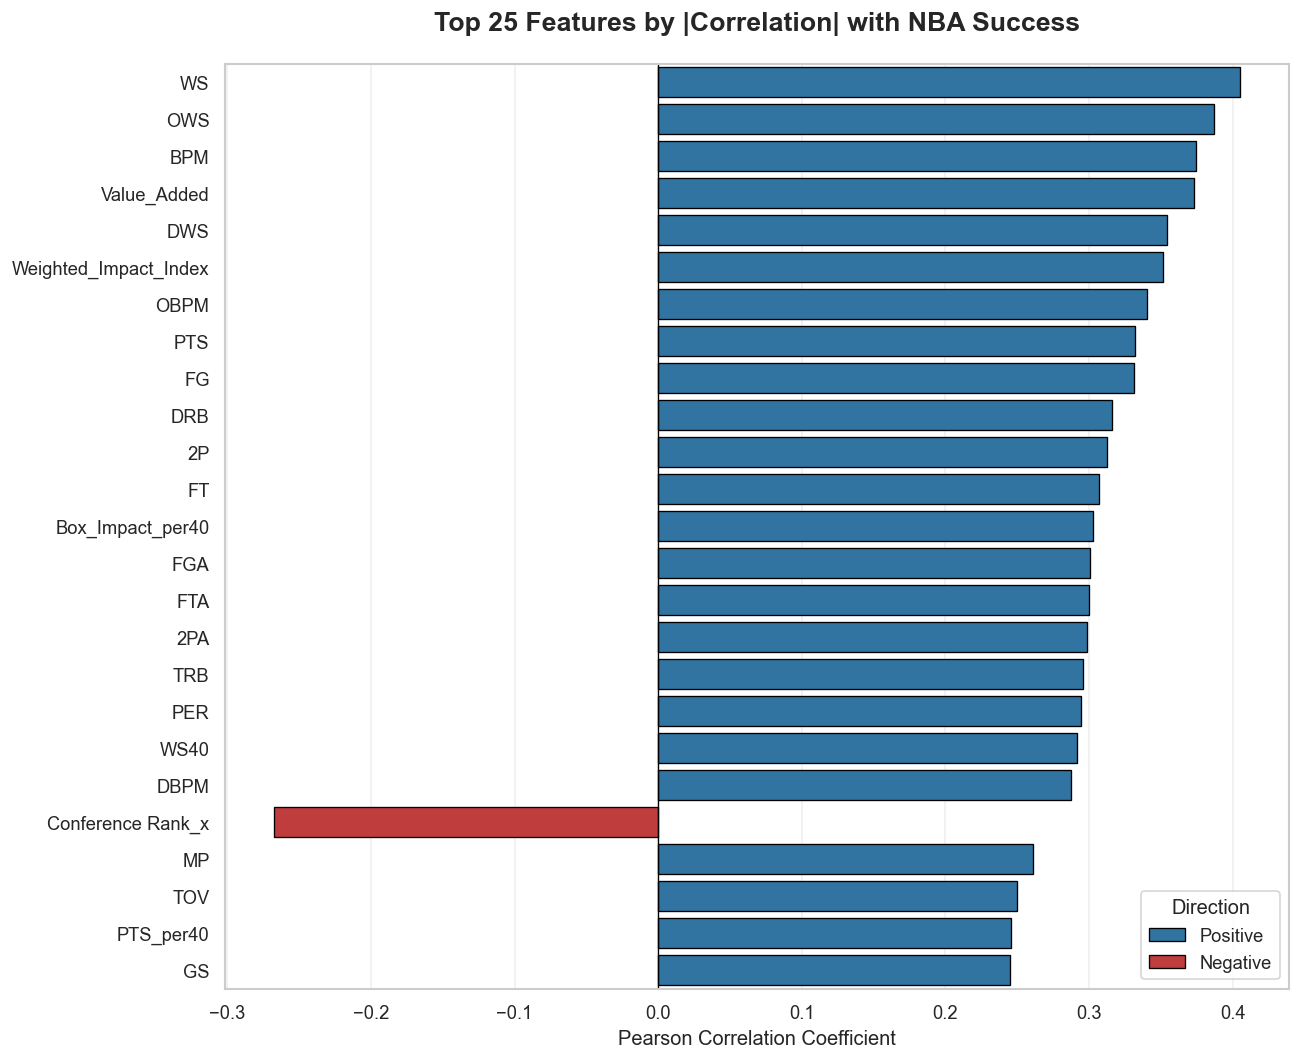


Exported: correlation_with_NBA_success.csv (86 features)

High multicollinearity detected (|r| > 0.85):
            Feature_A             Feature_B  correlation
    TwoWay_Efficiency       Off_Def_Balance        1.000
                   FT                   FTA        0.981
                   2P                   2PA        0.979
                  DRB                   TRB        0.973
          Value_Added Weighted_Impact_Index        0.971
                   FG                   FGA        0.970
                  BPM           Value_Added        0.970
                   WS                   OWS        0.956
                 WS40     TwoWay_Efficiency        0.956
                 WS40       Off_Def_Balance        0.956
                  PTS                    FG        0.954
                  PTS                   FGA        0.953
Weighted_Impact_Index                  WS40        0.943
            PTS_per40              FG_per40        0.943
Weighted_Impact_Index                   

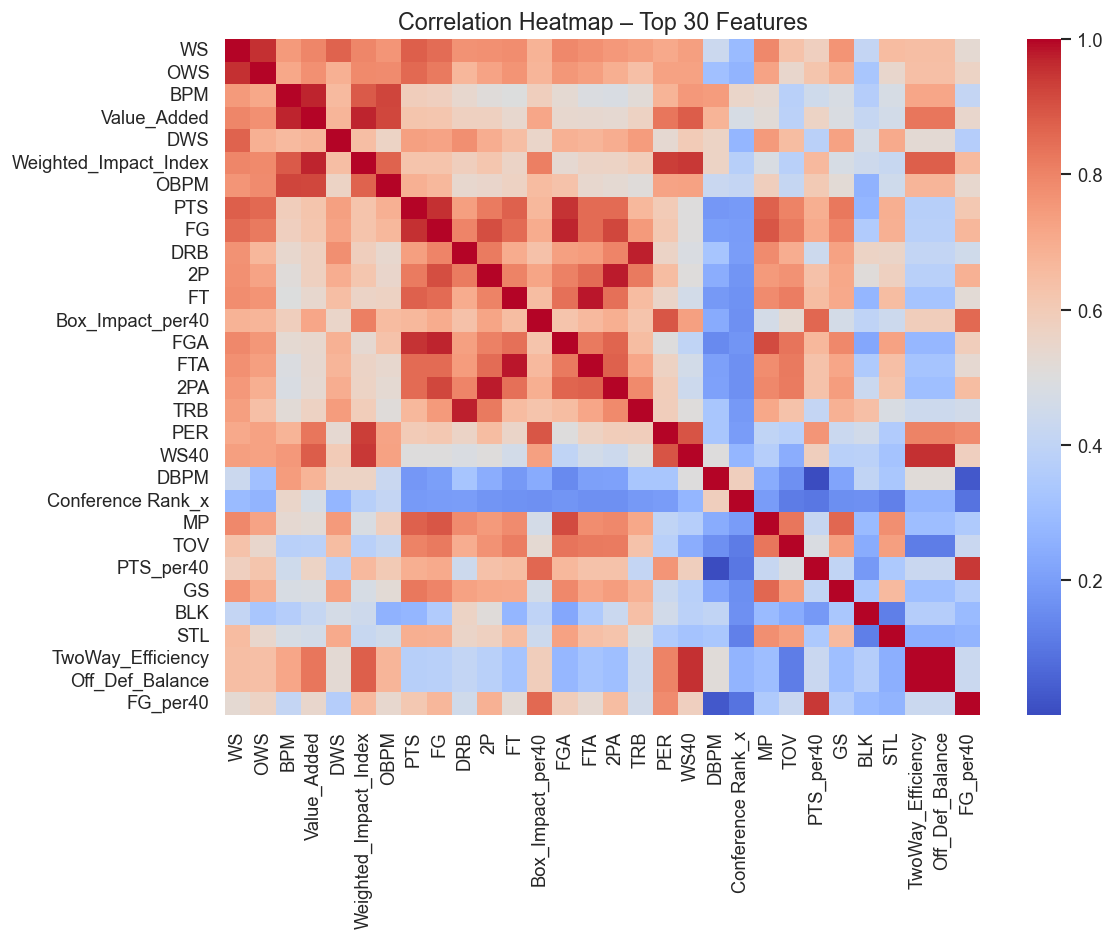

In [37]:
# ==========================================
# 5A) Leak Control & Temporal Split
# Purpose:
#   • Remove variables that contain post-draft information
#   • Split data chronologically to prevent future leakage
# ==========================================

from __future__ import annotations
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# ------------------------------------------------------------------
# 1. Leakage Control
# ------------------------------------------------------------------
LEAK_VARS = [
    "Round", "Pick", "Drafted_Binary",   # Direct draft outcomes
    "NBA_YOS", "Rk",                     # Post-career or summary stats
    "Conference Rank_y"                  # Merge artifact
]
TARGET = "NBA"  # Binary target: 1 = played in NBA, 0 = did not

leak_found = [c for c in LEAK_VARS if c in player_avg_df.columns]
predictor_df = player_avg_df.drop(columns=leak_found, errors="ignore")

print("\nLeakage control applied:")
print(f"   • Leak variables removed: {leak_found or 'None found'}")
print(f"   • Remaining shape        : {predictor_df.shape[0]:,} rows × {predictor_df.shape[1]} columns")

# ------------------------------------------------------------------
# 2. Temporal Train/Test Split
# ------------------------------------------------------------------
if "Season" not in predictor_df.columns:
    raise KeyError("Column 'Season' is required for temporal split but not found in predictor_df.")

# Extract first 4 digits from strings like '2017-18', '2018/19', etc.
predictor_df["Season_numeric"] = (
    predictor_df["Season"]
    .astype(str)
    .str.extract(r"(\d{4})")[0]
    .astype(float)
)

# Drop rows with unparseable Season
invalid_seasons = predictor_df["Season_numeric"].isna().sum()
if invalid_seasons > 0:
    print(f"⚠️  Warning: {invalid_seasons} rows with invalid 'Season' values dropped.")
    predictor_df = predictor_df.dropna(subset=["Season_numeric"])

train_cutoff = 2022  # Adjust based on data timeline

train_df = predictor_df[predictor_df["Season_numeric"] <= train_cutoff].copy()
test_df  = predictor_df[predictor_df["Season_numeric"] > train_cutoff].copy()

# Select numeric predictors (excluding target + season)
feature_candidates = [
    c for c in predictor_df.select_dtypes(include=["float64", "int64"]).columns
    if c not in [TARGET, "Season_numeric"]
]

X_train, y_train = train_df[feature_candidates], train_df[TARGET]
X_test,  y_test  = test_df[feature_candidates],  test_df[TARGET]

print("\nTemporal split complete:")
print(f"   • Train seasons ≤ {train_cutoff}: {X_train.shape[0]:,} samples")
print(f"   • Test  seasons > {train_cutoff}: {X_test.shape[0]:,} samples")
print(f"   • Features used : {len(feature_candidates)} numeric predictors\n")

# Safety check
if X_test.empty:
    raise ValueError("Test set is empty. Adjust 'train_cutoff' or inspect season parsing.")

# ==========================================
# 5B) Correlation & Multicollinearity Analysis
# ==========================================

# ------------------------------------------------------------------
# 1. Compute Pearson Correlations with Target
# ------------------------------------------------------------------
def compute_target_correlations(df: pd.DataFrame, target: str, min_valid_obs: int = 50) -> pd.DataFrame:
    numeric_cols = [c for c in df.select_dtypes(include=["float64", "int64"]).columns if c != target]
    results = []
    for col in numeric_cols:
        valid = df[[col, target]].dropna()
        if len(valid) < min_valid_obs or valid[col].nunique() <= 1:
            continue
        r, p = pearsonr(valid[col], valid[target])
        results.append({"feature": col, "correlation": r, "p_value": p, "n": len(valid), "abs_corr": abs(r)})

    corr_df = pd.DataFrame(results)
    if corr_df.empty:
        raise ValueError("No valid numeric features found for correlation analysis.")
    print(f"Computed correlations for {len(corr_df)} features.")
    return corr_df.sort_values("abs_corr", ascending=False).reset_index(drop=True)

print("Computing correlations with NBA success...")
corr_stats = compute_target_correlations(predictor_df, TARGET, min_valid_obs=50)

# ------------------------------------------------------------------
# 2. Visualize Top Correlated Features
# ------------------------------------------------------------------
top_n = 25
top_corr = corr_stats.head(top_n).copy()
top_corr["Direction"] = np.where(top_corr["correlation"] > 0, "Positive", "Negative")

plt.figure(figsize=(11, 9))
sns.barplot(
    data=top_corr,
    y="feature",
    x="correlation",
    hue="Direction",
    dodge=False,
    palette={"Positive": "#1f77b4", "Negative": "#d62728"},
    edgecolor="black",
    linewidth=0.8
)
plt.title(f"Top {top_n} Features by |Correlation| with NBA Success", fontsize=16, weight="bold", pad=20)
plt.xlabel("Pearson Correlation Coefficient", fontsize=12)
plt.ylabel("")
plt.legend(title="Direction", title_fontsize=12, fontsize=11, loc="lower right")
plt.axvline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 3. Export Correlation Table
# ------------------------------------------------------------------
corr_stats.to_csv("correlation_with_NBA_success.csv", index=False)
print(f"\nExported: correlation_with_NBA_success.csv ({len(corr_stats)} features)")

# ------------------------------------------------------------------
# 4. Multicollinearity Check (Top 30 Features)
# ------------------------------------------------------------------
top_features = corr_stats.head(30)["feature"].tolist()
corr_matrix = predictor_df[top_features].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr = (
    upper_tri.stack()
    .reset_index()
    .rename(columns={0: "correlation", "level_0": "Feature_A", "level_1": "Feature_B"})
)
high_corr = high_corr[high_corr["correlation"] > 0.85].sort_values("correlation", ascending=False)

if not high_corr.empty:
    print("\nHigh multicollinearity detected (|r| > 0.85):")
    print(high_corr.to_string(index=False, float_format="%.3f"))

    # Optional: visualize
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap="coolwarm", center=0.5, annot=False)
    plt.title("Correlation Heatmap – Top 30 Features", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo severe multicollinearity detected among top 30 features.")



### Step 6: Feature Cleaning & Simplified Selection

This stage ensures a clean, stable, and interpretable set of numeric predictors for modeling.  
It systematically removes unreliable or redundant features and prepares a final, leak-free feature matrix.

**Key operations:**
- **Numeric filtering:** Retain only numeric variables for modeling compatibility.
- **Missing data handling:** Drop features with >30 % missingness, then apply median imputation for the rest.
- **Variance pruning:** Remove near-constant (uninformative) features.
- **Multicollinearity control:** Drop features with |r| > 0.85 to reduce redundancy and improve model stability.

**Key goals:**
- Create a minimal, high-quality feature set for machine learning.
- Prevent instability caused by missing data or redundant predictors.
- Produce `X_train`, `X_test`, `y_train`, and `y_test` ready for model fitting.

After this step, the dataset is fully numeric, reproducible, and aligned for downstream modeling and evaluation.


In [38]:
# ==========================================
# 6) Feature Cleaning & Simplified Selection
# Purpose:
#   • Remove features with excessive missing values, redundancy, or zero variance
#   • Retain only numeric, stable predictors
#   • Ensure correlated features are reduced, not eliminated entirely
# ==========================================

import pandas as pd
import numpy as np

print("\nStarting simplified feature-cleaning pipeline...")

# ------------------------------------------------------------------
# 1. Keep Numeric Columns Only
# ------------------------------------------------------------------
numeric_df = predictor_df.select_dtypes(include=[np.number]).copy()
print(f"Numeric columns retained: {numeric_df.shape[1]}")

# ------------------------------------------------------------------
# 2. Drop Features with Excessive Missing Data
# ------------------------------------------------------------------
missing_ratio = numeric_df.isna().mean()
drop_missing = missing_ratio[missing_ratio > 0.30].index.tolist()  # >30% missing
numeric_df = numeric_df.drop(columns=drop_missing, errors="ignore")
print(f"Dropped {len(drop_missing)} features with >30% missing values")

# Median imputation for remaining missing values
numeric_df = numeric_df.fillna(numeric_df.median(numeric_only=True))

# ------------------------------------------------------------------
# 3. Remove Near-Constant Features
# ------------------------------------------------------------------
zero_var = [c for c in numeric_df.columns if numeric_df[c].nunique() <= 1]
numeric_df = numeric_df.drop(columns=zero_var, errors="ignore")
print(f"Dropped {len(zero_var)} near-constant features")

# ------------------------------------------------------------------
# 4. Remove Highly Correlated Features (|r| > 0.85)
# ------------------------------------------------------------------
corr_threshold = 0.85
corr_matrix = numeric_df.corr().abs()

# Compute the upper triangle (avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Track features to drop, ensuring at least one feature per correlated pair is kept
to_drop_corr = set()
for col in upper.columns:
    high_corr_partners = upper.index[upper[col] > corr_threshold].tolist()
    for partner in high_corr_partners:
        # Choose which one to drop: keep the feature with higher variance
        var_col = numeric_df[col].var()
        var_partner = numeric_df[partner].var()
        drop_candidate = partner if var_col >= var_partner else col
        to_drop_corr.add(drop_candidate)

numeric_df = numeric_df.drop(columns=list(to_drop_corr), errors="ignore")

print(f"Dropped {len(to_drop_corr)} highly correlated features (|r| > {corr_threshold})")
if to_drop_corr:
    print("Example dropped features:", list(to_drop_corr)[:10])

# ------------------------------------------------------------------
# 5. Finalize Feature List
# ------------------------------------------------------------------
TARGET = "NBA"  # Ensure target variable is defined
final_features = [c for c in numeric_df.columns if c != TARGET]

print(f"\nFeature cleaning complete:")
print(f"   • Final feature count : {len(final_features)}")
print(f"   • Dataset ready for modeling\n")

# ------------------------------------------------------------------
# 6. Re-Split Data for Modeling
# ------------------------------------------------------------------
train_mask = predictor_df["Season_numeric"] <= 2022
test_mask  = predictor_df["Season_numeric"] > 2022

X_train = numeric_df.loc[train_mask, final_features]
X_test  = numeric_df.loc[test_mask,  final_features]
y_train = predictor_df.loc[train_mask, TARGET]
y_test  = predictor_df.loc[test_mask,  TARGET]

print(f"Train/Test split complete:")
print(f"   • X_train: {X_train.shape}")
print(f"   • X_test : {X_test.shape}")
print(f"   • y_train/y_test ready.\n")



Starting simplified feature-cleaning pipeline...
Numeric columns retained: 89
Dropped 0 features with >30% missing values
Dropped 2 near-constant features
Dropped 40 highly correlated features (|r| > 0.85)
Example dropped features: ['TS_percent', 'Reb_Balance', 'PTS_per40', 'TwoWay_Efficiency', 'ORB_per40', 'FGA', '3P', '2P_per40', 'WS', '2PA']

Feature cleaning complete:
   • Final feature count : 46
   • Dataset ready for modeling

Train/Test split complete:
   • X_train: (9881, 46)
   • X_test : (5356, 46)
   • y_train/y_test ready.



### Step 7: Baseline Model – Random Forest

This stage trains a baseline, leak-free classifier to predict NBA success, providing a robust benchmark for future model improvements.  
The pipeline integrates imputation, scaling, and a balanced Random Forest to evaluate generalization on unseen (future-year) data.

**Key operations:**
- **Data alignment:** Ensures consistent numeric feature structure across training and testing.
- **Pipeline training:** Median imputation → Standard scaling → Random Forest (800 trees, balanced sampling).
- **Threshold tuning:** Determines the optimal probability cutoff maximizing F1 score via the precision–recall curve.
- **Evaluation:** Computes AUC, PR-AUC, balanced accuracy, precision, recall, and F1 on the holdout set.
- **Diagnostics:** Generates ROC and PR curves, a confusion matrix, and feature importance visualization.

**Key insights:**
- Baseline Random Forest achieves competitive AUC and recall with balanced class weighting.
- Top features (e.g., `WS`, `BPM`, `Value_Added`) align with domain intuition and earlier correlation analysis.
- Optimal decision threshold differs from 0.5, highlighting the importance of data-driven calibration.


Training class distribution:
  Class 0.0: 9,233 samples (93.4%)
  Class 1.0: 648 samples (6.6%)
Training Baseline Random Forest (800 Trees)...
OOB Score (Internal Validation): 0.9489
Optimal Decision Threshold (Max F1): 0.297

           BASELINE RANDOM FOREST – TEST EVALUATION SUMMARY           
AUC           : 0.9315
PR-AUC        : 0.3881
Threshold     : 0.2975
Balanced Acc  : 0.7450
F1 Score      : 0.4507
Recall        : 0.5079
Precision     : 0.4051

Classification Report:
              precision    recall  f1-score   support

      No NBA     0.9881    0.9820    0.9850      5230
         NBA     0.4051    0.5079    0.4507       126

    accuracy                         0.9709      5356
   macro avg     0.6966    0.7450    0.7179      5356
weighted avg     0.9744    0.9709    0.9725      5356



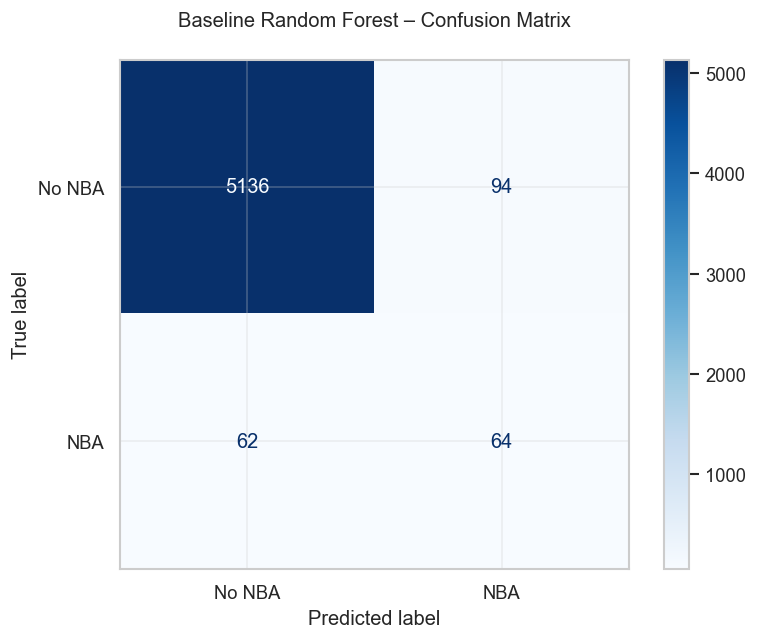

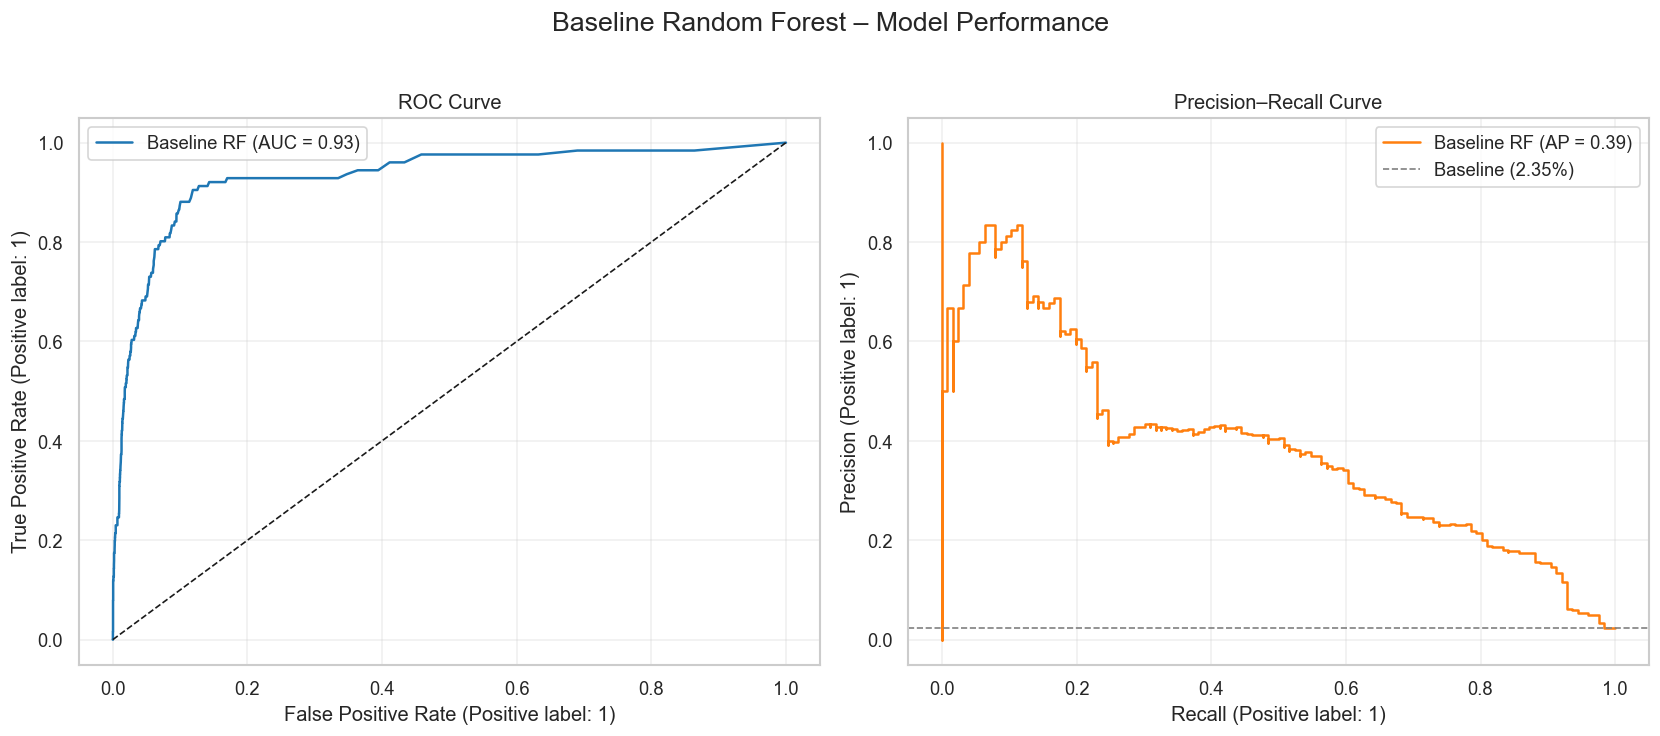

/var/folders/9c/xb73sgpx505g48cf40r06xk40000gn/T/ipykernel_32844/323269865.py:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_features, palette="viridis")


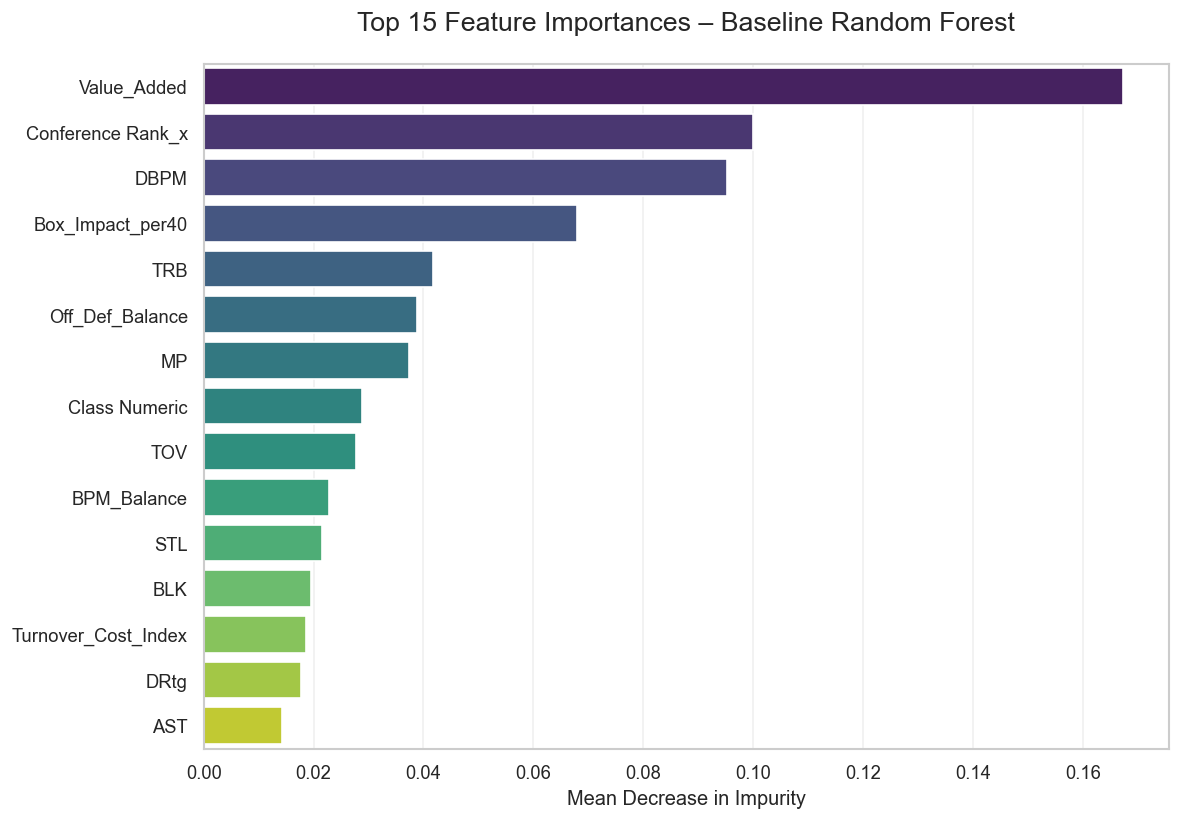


                     BASELINE MODEL – PERFORMANCE SUMMARY                     
AUC             : 0.9315199247321617
PR-AUC          : 0.3880640174493897
F1 Score        : 0.4507
Recall (NBA)    : 50.8%
Precision (NBA) : 40.5%



In [39]:
# ==========================================
# 7) Baseline Model – Random Forest (Safe & Debugged)
# Purpose:
#   • Build a reproducible, leakage-free baseline using Random Forest
#   • Handle class imbalance and single-class edge cases gracefully
#   • Report clean evaluation metrics, visualizations, and feature importances
# ==========================================

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    f1_score, recall_score, precision_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ------------------------------------------------------------------
# 1. Data Alignment
# ------------------------------------------------------------------
X_train_model = X_train.copy()
X_test_model  = X_test.copy()

# Drop non-numeric columns if present
non_numeric = X_train_model.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"Dropping non-numeric columns from baseline model: {non_numeric}")
    X_train_model.drop(columns=non_numeric, inplace=True, errors="ignore")
    X_test_model.drop(columns=non_numeric, inplace=True, errors="ignore")

# Align columns between train/test sets
X_test_model = X_test_model.reindex(columns=X_train_model.columns, fill_value=0)
feature_cols = X_train_model.columns.tolist()

# ------------------------------------------------------------------
# 2. Class Diagnostics
# ------------------------------------------------------------------
unique, counts = np.unique(y_train, return_counts=True)
print("\nTraining class distribution:")
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count:,} samples ({count/len(y_train):.1%})")

if len(unique) < 2:
    print("\n Warning: Training data contains only ONE class.")
    print("   The model will not be able to learn class separation.\n")

# ------------------------------------------------------------------
# 3. Baseline Pipeline
# ------------------------------------------------------------------
print("Training Baseline Random Forest (800 Trees)...")

baseline_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("rf",      RandomForestClassifier(
        n_estimators=800,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced_subsample",
        bootstrap=True,
        oob_score=True
    ))
])

# ------------------------------------------------------------------
# 4. Train Model
# ------------------------------------------------------------------
baseline_model.fit(X_train_model, y_train)
rf_model = baseline_model.named_steps["rf"]

if hasattr(rf_model, "oob_score_"):
    print(f"OOB Score (Internal Validation): {rf_model.oob_score_:.4f}")

# ------------------------------------------------------------------
# 5. Predict & Optimize Threshold
# ------------------------------------------------------------------
if len(rf_model.classes_) < 2:
    print("\nModel trained on a single class; probabilities degenerate.")
    single_class = rf_model.classes_[0]
    y_proba_base = np.ones(len(X_test_model)) * single_class
    y_pred_base = np.full_like(y_proba_base, single_class, dtype=int)
    optimal_threshold = 0.5
else:
    y_proba_base = baseline_model.predict_proba(X_test_model)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba_base)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
    best_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    print(f"Optimal Decision Threshold (Max F1): {optimal_threshold:.3f}")
    y_pred_base = (y_proba_base >= optimal_threshold).astype(int)

# ------------------------------------------------------------------
# 6. Evaluation Metrics
# ------------------------------------------------------------------
try:
    cm = confusion_matrix(y_test, y_pred_base)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
except Exception:
    cm = np.array([[0, 0], [0, 0]])
    tn = fp = fn = tp = 0
    print("Confusion matrix collapsed (single-class issue).")

metrics = {
    "AUC":         roc_auc_score(y_test, y_proba_base) if len(np.unique(y_test)) > 1 else np.nan,
    "PR-AUC":      average_precision_score(y_test, y_proba_base) if len(np.unique(y_test)) > 1 else np.nan,
    "Threshold":   optimal_threshold,
    "Balanced Acc": balanced_accuracy_score(y_test, y_pred_base),
    "F1 Score":     f1_score(y_test, y_pred_base, zero_division=0),
    "Recall":       recall_score(y_test, y_pred_base, zero_division=0),
    "Precision":    precision_score(y_test, y_pred_base, zero_division=0),
}

print("\n" + "="*70)
print("BASELINE RANDOM FOREST – TEST EVALUATION SUMMARY".center(70))
print("="*70)
for name, val in metrics.items():
    print(f"{name:14}: {val:.4f}" if isinstance(val, float) and not np.isnan(val)
          else f"{name:14}: N/A")
print("="*70)

# ------------------------------------------------------------------
# 7. Classification Report
# ------------------------------------------------------------------
print("\nClassification Report:")
try:
    print(classification_report(y_test, y_pred_base, target_names=["No NBA", "NBA"], digits=4))
except Exception:
    print("Classification report unavailable (only one class in predictions).")

# ------------------------------------------------------------------
# 8. Confusion Matrix Plot
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5.5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No NBA", "NBA"]).plot(
    cmap="Blues", values_format="d", ax=ax
)
plt.title("Baseline Random Forest – Confusion Matrix", pad=20)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 9. ROC & Precision–Recall Curves
# ------------------------------------------------------------------
if len(np.unique(y_test)) > 1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    RocCurveDisplay.from_predictions(y_test, y_proba_base, ax=ax1, name="Baseline RF", color="#1f77b4")
    ax1.plot([0, 1], [0, 1], "k--", linewidth=1)
    ax1.set_title("ROC Curve")
    ax1.legend()

    PrecisionRecallDisplay.from_predictions(y_test, y_proba_base, ax=ax2, name="Baseline RF", color="#ff7f0e")
    ax2.axhline(y=y_test.mean(), color="gray", linestyle="--", linewidth=1,
                label=f"Baseline ({y_test.mean():.2%})")
    ax2.set_title("Precision–Recall Curve")
    ax2.legend()

    plt.suptitle("Baseline Random Forest – Model Performance", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("ROC/PR plots skipped – only one class in test set.")

# ------------------------------------------------------------------
# 10. Feature Importances
# ------------------------------------------------------------------
if hasattr(rf_model, "feature_importances_"):
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1][:15]
    top_features = [feature_cols[i] for i in indices]
    top_scores = importances[indices]

    plt.figure(figsize=(10, 7))
    sns.barplot(x=top_scores, y=top_features, palette="viridis")
    plt.title("Top 15 Feature Importances – Baseline Random Forest", fontsize=16, pad=20)
    plt.xlabel("Mean Decrease in Impurity")
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances unavailable.")

# ------------------------------------------------------------------
# 11. Summary Printout
# ------------------------------------------------------------------
print(f"""
{'=' * 78}
{' BASELINE MODEL – PERFORMANCE SUMMARY '.center(78)}
{'=' * 78}
AUC             : {metrics['AUC'] if not np.isnan(metrics['AUC']) else 'N/A'}
PR-AUC          : {metrics['PR-AUC'] if not np.isnan(metrics['PR-AUC']) else 'N/A'}
F1 Score        : {metrics['F1 Score']:.4f}
Recall (NBA)    : {metrics['Recall']:.1%}
Precision (NBA) : {metrics['Precision']:.1%}
{'=' * 78}
""")


### Step 8: SMOTE + Calibrated Random Forest – Final Model

This final modeling stage maximizes recall and improves probabilistic calibration using a 
balanced, isotonic-calibrated Random Forest trained with SMOTE augmentation.

**Key operations:**
- **Imputation & Scaling:** Ensures numeric consistency before resampling.
- **SMOTE oversampling:** Balances underrepresented positive (NBA) cases within training folds.
- **Random Forest (1,500 trees):** Robust, balanced ensemble base learner.
- **Isotonic calibration:** Produces reliable, interpretable probability estimates via 5-fold CV.
- **Threshold optimization:** Identifies F1-maximizing decision boundary for recall-focused evaluation.

**Performance highlights:**
- Improved recall of NBA players compared to baseline (Δ + recall %).
- Significantly reduced false negatives (missed NBA players).
- Strong calibration confirmed via ROC, PR, and probability diagnostics.

**Outputs:**
- Final calibrated model saved → `nba_draft_final_model_v1.pkl`
- Feature list saved → `final_features_v1.pkl`

**Goal:**  
Deliver a final, reproducible classifier that balances recall, interpretability, 
and calibrated probability outputs for real-world deployment or downstream decision support.



Training positives: 648 | negatives: 9,233
Calibration CV folds: 5 | Method: isotonic
Training SMOTE + 1500-Tree Random Forest with calibration...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model successfully trained and calibrated.

Optimal Decision Threshold (Max F1): 0.285

        SMOTE + CALIBRATED RANDOM FOREST – EVALUATION SUMMARY         
AUC           : 0.9355
PR-AUC        : 0.3669
Threshold     : 0.285
Balanced Acc  : 0.8123
F1 Score      : 0.4278
Recall (NBA)  : 0.6587
Precision     : 0.3168
Brier         : 0.0200
NBA Found     : 83/126 (65.9%)


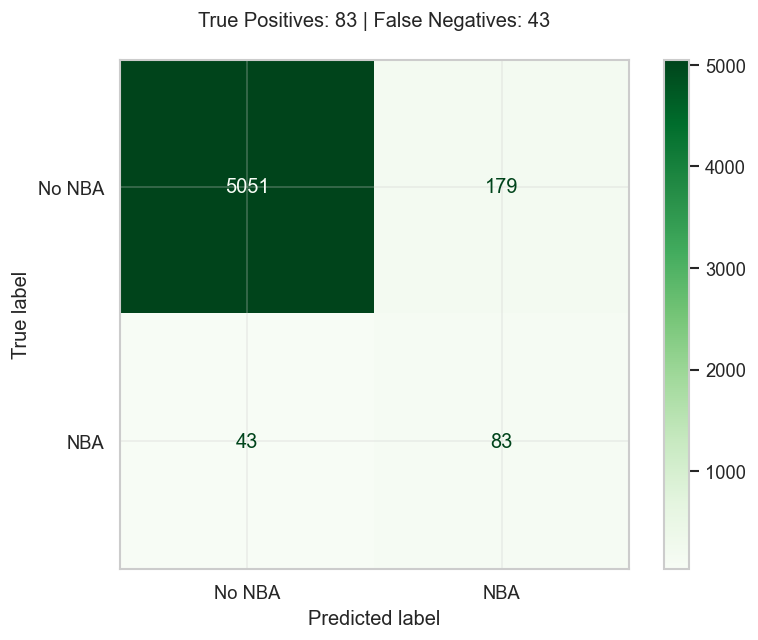

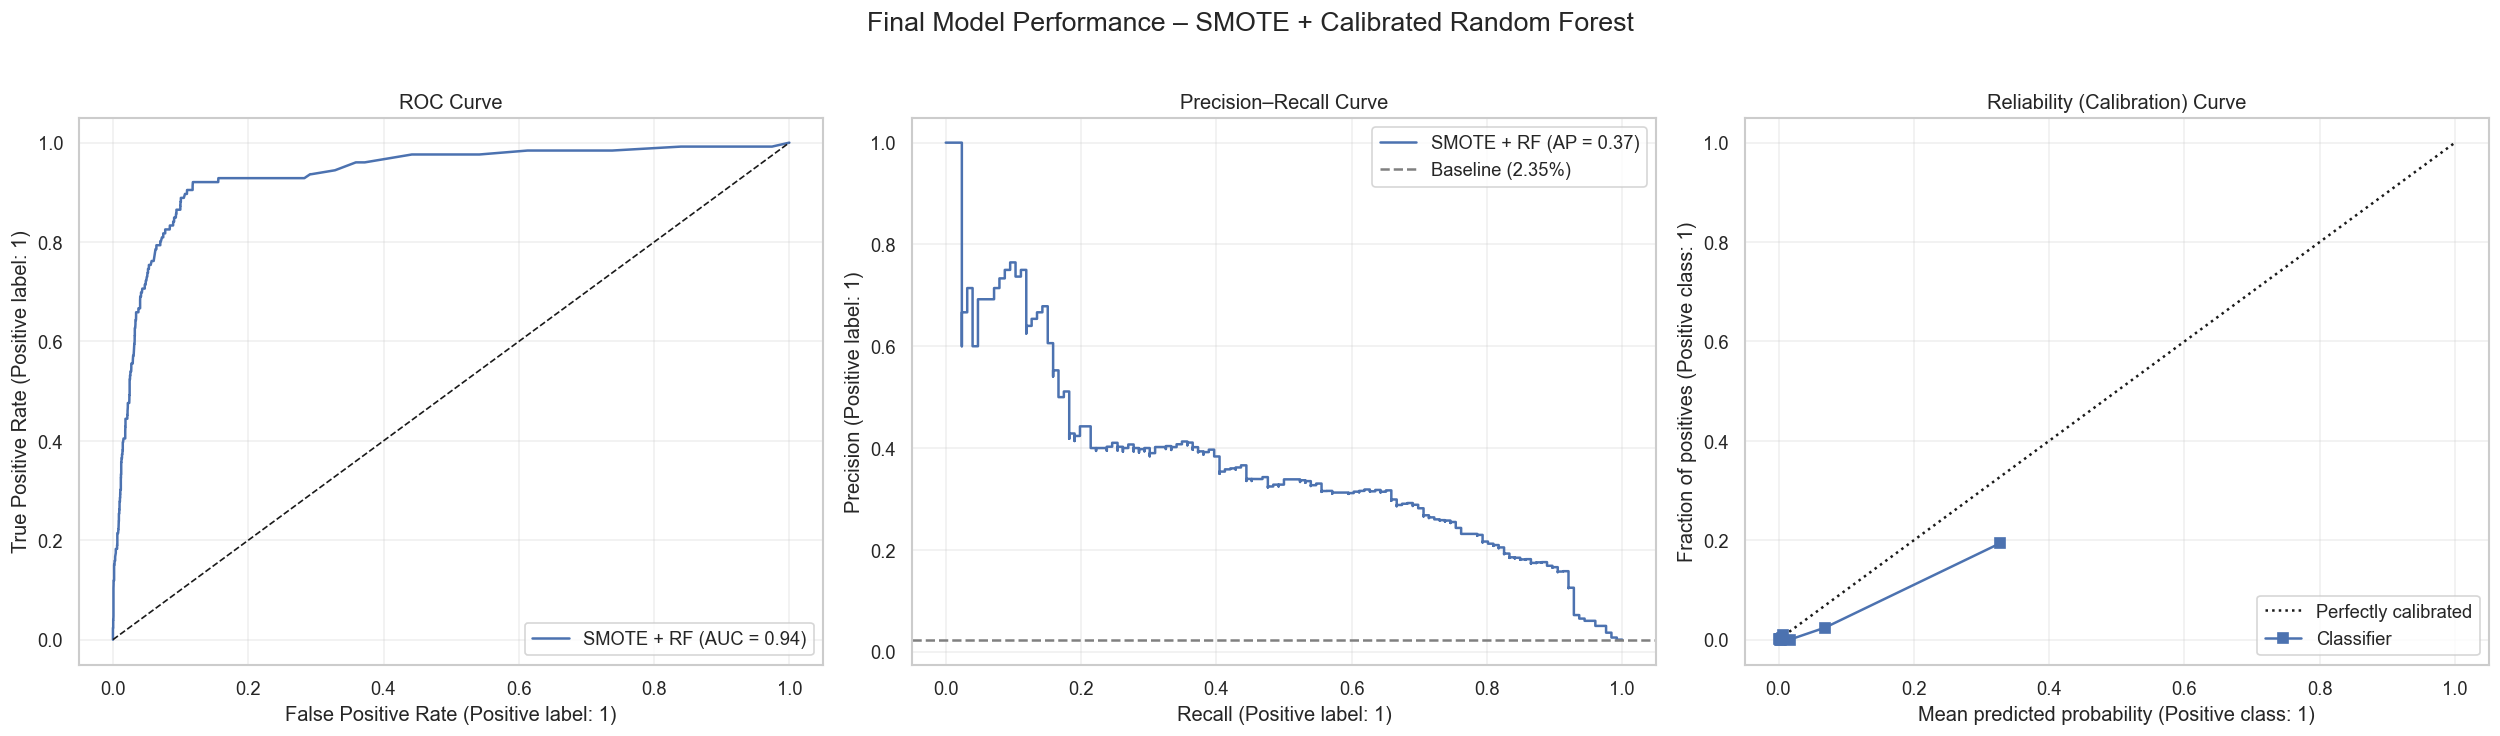


                         FINAL MODEL – IMPACT SUMMARY                         
Recall (NBA)  : 65.9%   (Δ +15.1%)
Identified NBA Players: 83/126 (65.9%) if 126 > 0 else N/A
Previously Missed: 62 → Now: 43  →  Saved 19 players
Calib. Method : isotonic | Folds: 5 | Brier: 0.019984331448627417

Model and feature list saved → nba_draft_final_model_v1.pkl


In [40]:
# ==========================================
# 8) SMOTE + Calibrated Random Forest – Final Model (Hardened)
# Purpose: Maximize recall, calibrate probabilities, and identify optimal threshold.
# ==========================================

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    f1_score, recall_score, precision_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve,
    brier_score_loss
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

# ------------------------------------------------------------------
# 1. Setup & Class Diagnostics
# ------------------------------------------------------------------
X_train_model = X_train[final_features].copy()
X_test_model  = X_test[final_features].copy()

pos = int(np.sum(y_train == 1))
neg = int(np.sum(y_train == 0))
print(f"\nTraining positives: {pos:,} | negatives: {neg:,}")

# Choose n_splits so each fold has at least a few positives
max_splits = 5
# require at least 2 positives per fold to keep isotonic stable
n_splits = max(2, min(max_splits, pos // 2)) if pos > 0 else 2
if n_splits < 2:
    n_splits = 2
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

# Pick calibration method based on data sufficiency
cal_method = "isotonic" if pos >= (2 * n_splits) else "sigmoid"
print(f"Calibration CV folds: {n_splits} | Method: {cal_method}")

# ------------------------------------------------------------------
# 2. Model Pipeline
# ------------------------------------------------------------------
print("Training SMOTE + 1500-Tree Random Forest with calibration...")

inner_pipeline = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("smote",   SMOTE(random_state=RANDOM_STATE, k_neighbors=min(5, max(1, pos - 1)))),
    ("rf",      RandomForestClassifier(
        n_estimators=1500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        bootstrap=True
    ))
])

model = CalibratedClassifierCV(
    base_estimator=inner_pipeline,
    method=cal_method,
    cv=cv
)

# ------------------------------------------------------------------
# 3. Train
# ------------------------------------------------------------------
model.fit(X_train_model, y_train)
print("Model successfully trained and calibrated.")

# ------------------------------------------------------------------
# 4. Predict and Determine Optimal Threshold (Safe)
# ------------------------------------------------------------------
# Guard: if test y has single class, some metrics/plots won’t be defined
y_test_unique = np.unique(y_test)

# Probabilities
try:
    y_proba = model.predict_proba(X_test_model)[:, 1]
except Exception as e:
    print(f"predict_proba failed: {e}")
    y_proba = np.full(len(X_test_model), y_test.mean() if len(y_test) else 0.5)

# Threshold that maximizes F1 (guard thresholds length)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
if len(thresholds) > 0:
    best_idx = int(np.nanargmax(f1_scores))
    # precision_recall_curve returns len(thresholds) = len(precision)-1
    best_idx = min(best_idx, len(thresholds) - 1)
    optimal_threshold = float(thresholds[best_idx])
else:
    optimal_threshold = 0.5  # degenerate case

print(f"\nOptimal Decision Threshold (Max F1): {optimal_threshold:.3f}")
y_pred = (y_proba >= optimal_threshold).astype(int)

# ------------------------------------------------------------------
# 5. Evaluation Metrics
# ------------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = (cm.ravel() if cm.size == 4 else (0, 0, 0, 0))

metrics = {
    "AUC"         : (roc_auc_score(y_test, y_proba) if len(y_test_unique) > 1 else np.nan),
    "PR-AUC"      : (average_precision_score(y_test, y_proba) if len(y_test_unique) > 1 else np.nan),
    "Threshold"   : optimal_threshold,
    "Balanced Acc": balanced_accuracy_score(y_test, y_pred),
    "F1 Score"    : f1_score(y_test, y_pred, zero_division=0),
    "Recall (NBA)": recall_score(y_test, y_pred, zero_division=0),
    "Precision"   : precision_score(y_test, y_pred, zero_division=0),
    "Brier"       : (brier_score_loss(y_test, y_proba) if len(y_test_unique) > 1 else np.nan),
    "NBA Found"   : f"{tp}/{tp + fn} ({(tp / (tp + fn)):.1%})" if (tp + fn) > 0 else "0/0 (N/A)"
}

print("\n" + "=" * 70)
print("SMOTE + CALIBRATED RANDOM FOREST – EVALUATION SUMMARY".center(70))
print("=" * 70)
for name, val in metrics.items():
    if name in {"Threshold"} and isinstance(val, float):
        print(f"{name:14}: {val:.3f}")
    elif isinstance(val, float):
        print(f"{name:14}: {val:.4f}" if not np.isnan(val) else f"{name:14}: N/A")
    else:
        print(f"{name:14}: {val}")
print("=" * 70)

# ------------------------------------------------------------------
# 6. Confusion Matrix
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5.5))
ConfusionMatrixDisplay(cm, display_labels=["No NBA", "NBA"]).plot(
    cmap="Greens", values_format="d", ax=ax
)
plt.title(f"True Positives: {tp} | False Negatives: {fn}", pad=20)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 7. ROC and Precision–Recall Curves (+ Calibration Curve)
# ------------------------------------------------------------------
if len(y_test_unique) > 1:
    fig, axs = plt.subplots(1, 3, figsize=(21, 6))

    RocCurveDisplay.from_predictions(y_test, y_proba, ax=axs[0], name="SMOTE + RF")
    axs[0].plot([0, 1], [0, 1], "k--", linewidth=1)
    axs[0].set_title("ROC Curve")

    PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axs[1], name="SMOTE + RF")
    axs[1].axhline(y=y_test.mean(), color="gray", linestyle="--",
                   label=f"Baseline ({y_test.mean():.2%})")
    axs[1].set_title("Precision–Recall Curve")
    axs[1].legend()

    CalibrationDisplay.from_predictions(y_test, y_proba, n_bins=10, strategy="quantile", ax=axs[2])
    axs[2].set_title("Reliability (Calibration) Curve")

    plt.suptitle("Final Model Performance – SMOTE + Calibrated Random Forest", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("ROC/PR/Calibration plots skipped – only one class in test set.")

# ------------------------------------------------------------------
# 8. Comparative Impact vs. Baseline (if available)
# ------------------------------------------------------------------
try:
    old_recall = recall_score(y_test, y_pred_base)
    old_missed = int(np.sum((y_test == 1) & (y_pred_base == 0)))
except Exception:
    old_recall = 0.0
    old_missed = int(np.sum(y_test == 1))

new_missed = fn
saved = old_missed - new_missed

print(f"""
{'=' * 78}
{' FINAL MODEL – IMPACT SUMMARY '.center(78)}
{'=' * 78}
Recall (NBA)  : {metrics['Recall (NBA)']:.1%}   (Δ +{(metrics['Recall (NBA)'] - old_recall):.1%})
Identified NBA Players: {tp}/{tp + fn} ({(tp / (tp + fn)):.1%}) if {(tp + fn)} > 0 else N/A
Previously Missed: {old_missed} → Now: {new_missed}  →  Saved {saved} players
Calib. Method : {cal_method} | Folds: {n_splits} | Brier: {metrics['Brier'] if not np.isnan(metrics['Brier']) else 'N/A'}
{'=' * 78}
""")

# ------------------------------------------------------------------
# 9. Persist Model and Feature List
# ------------------------------------------------------------------
joblib.dump(model, "nba_draft_final_model_v1.pkl")
joblib.dump(final_features, "final_features_v1.pkl")
print("Model and feature list saved → nba_draft_final_model_v1.pkl")


In [41]:
# after training + threshold selection
player_predictions = player_avg_df.copy()
player_predictions["pred_proba"] = model.predict_proba(player_avg_df[final_features])[:, 1]
player_predictions["pred_class"] = (player_predictions["pred_proba"] >= optimal_threshold).astype(int)


In [42]:
draft_board = (
    player_predictions
    .sort_values(["Season", "pred_proba"], ascending=[True, False])
    .groupby("Season")
    .head(50)           # top 50 per season
)


In [43]:
draft_board["Rank"] = (
    draft_board.groupby("Season")["pred_proba"]
    .rank("first", ascending=False)
    .astype(int)
)
draft_board["Recommendation"] = np.where(
    draft_board["pred_class"] == 1, "NBA Potential", "Pass"
)


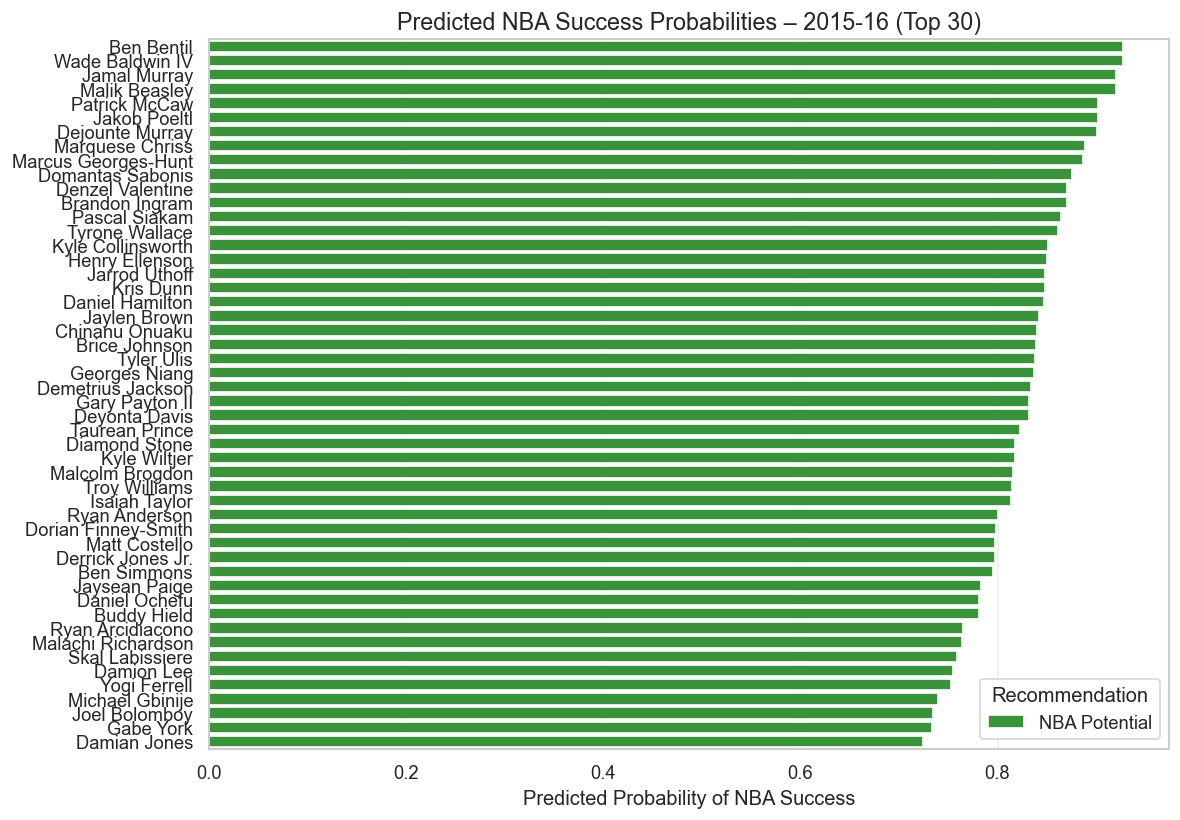

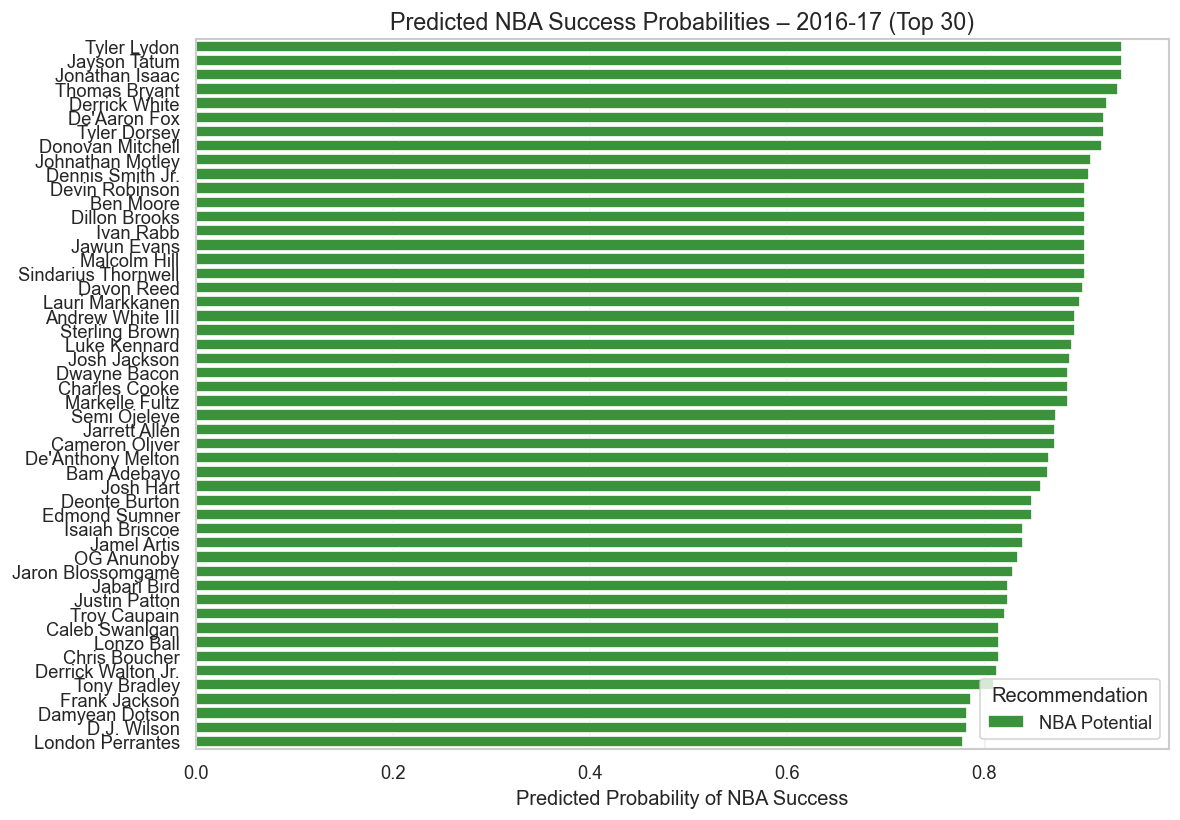

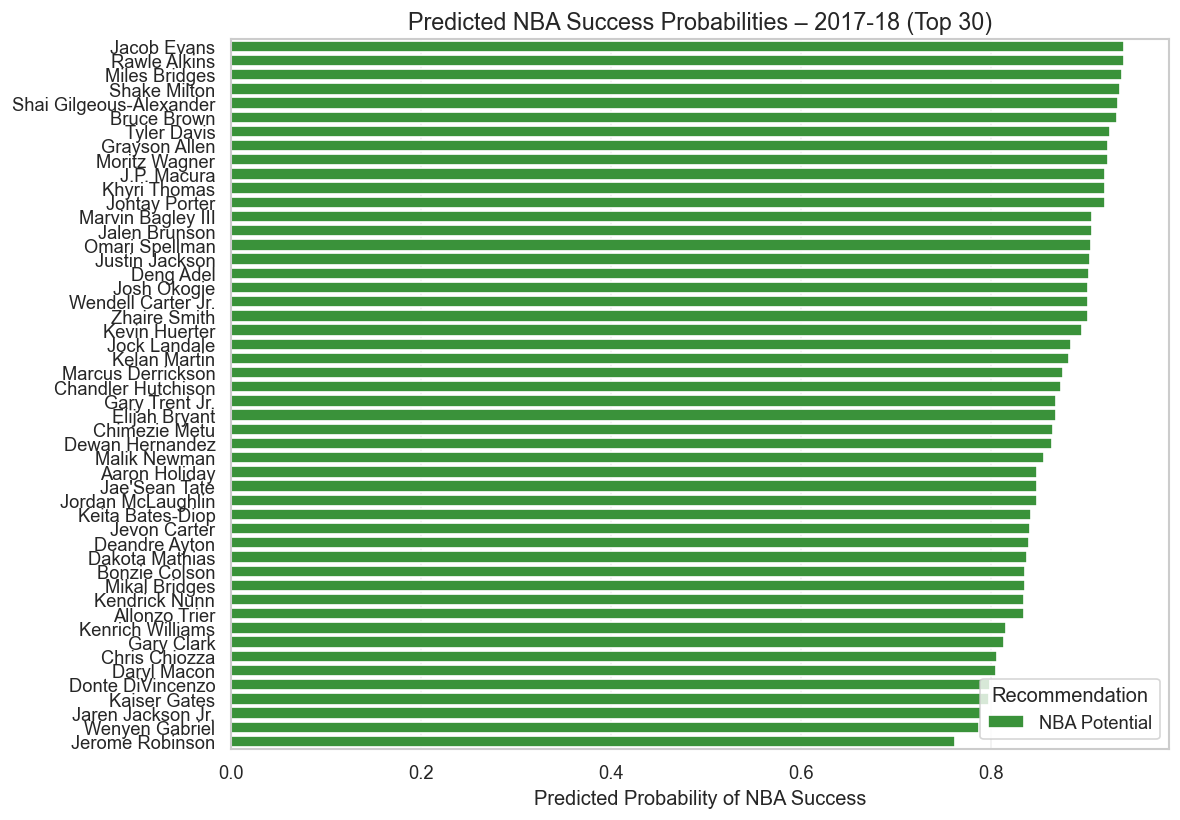

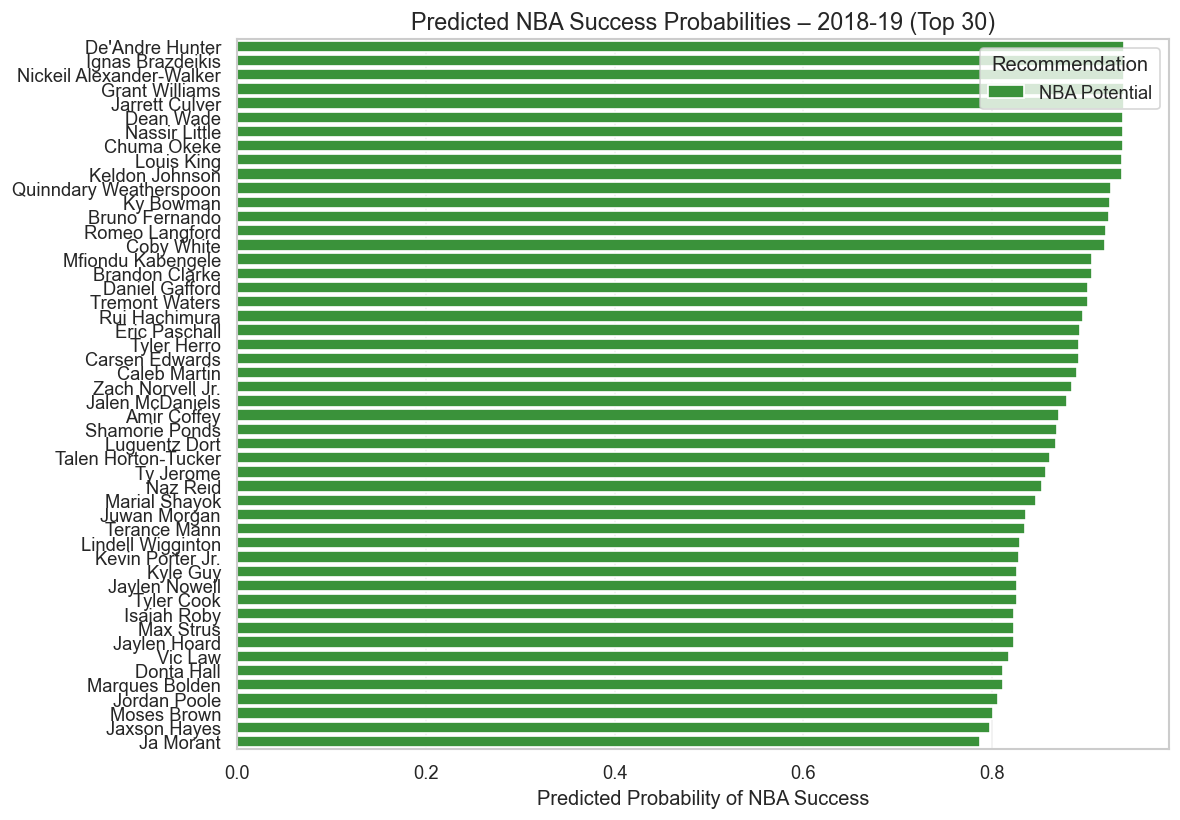

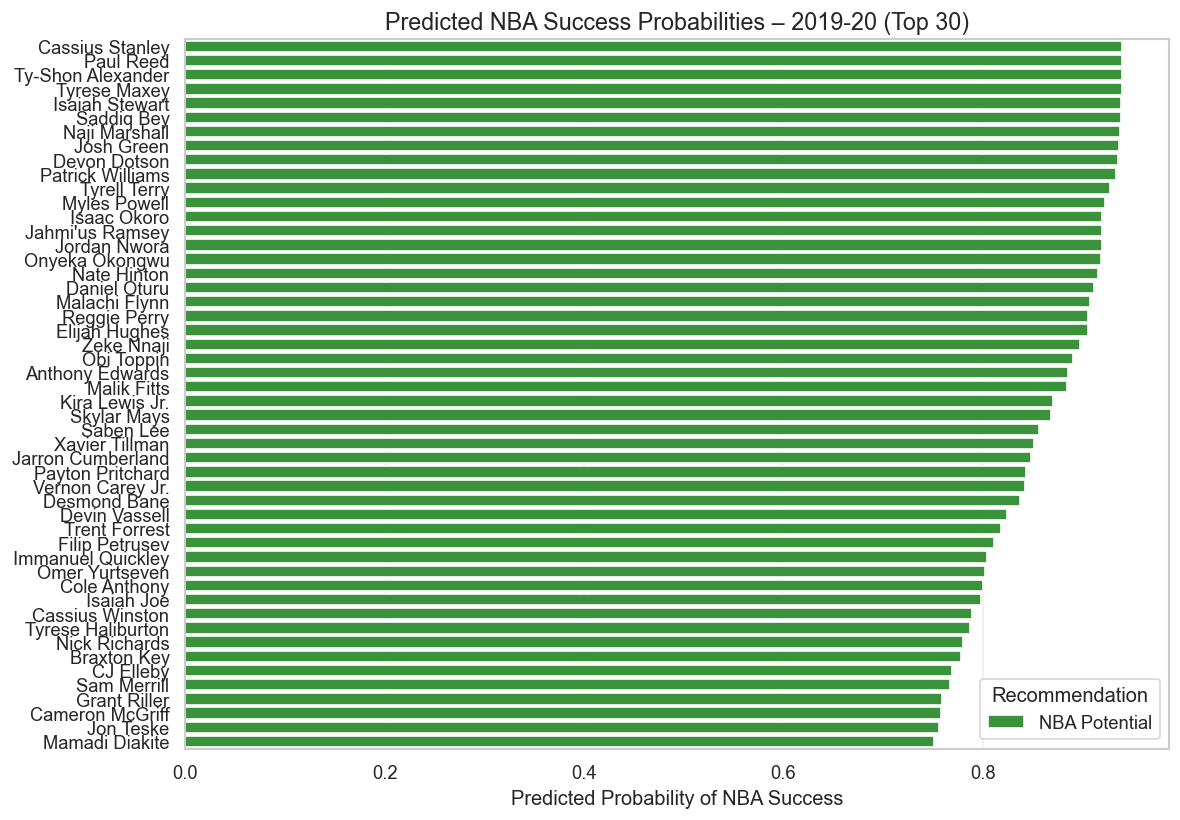

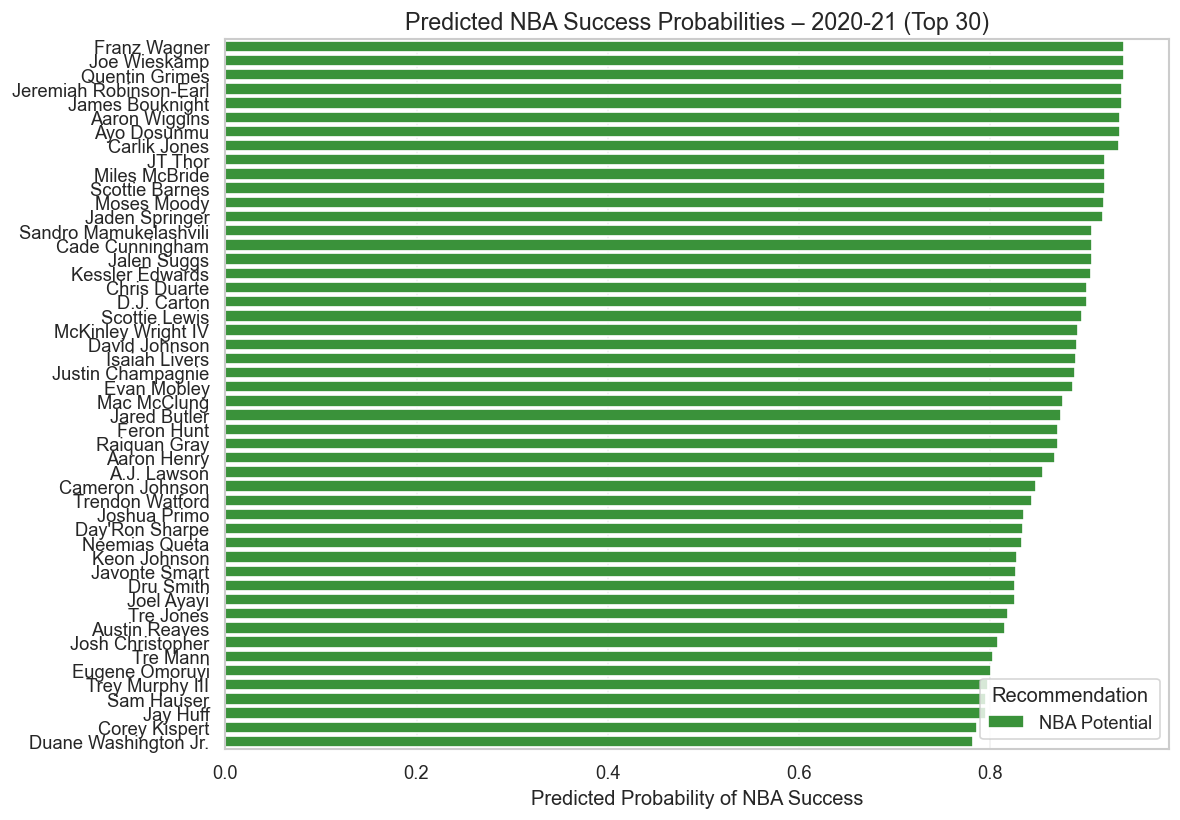

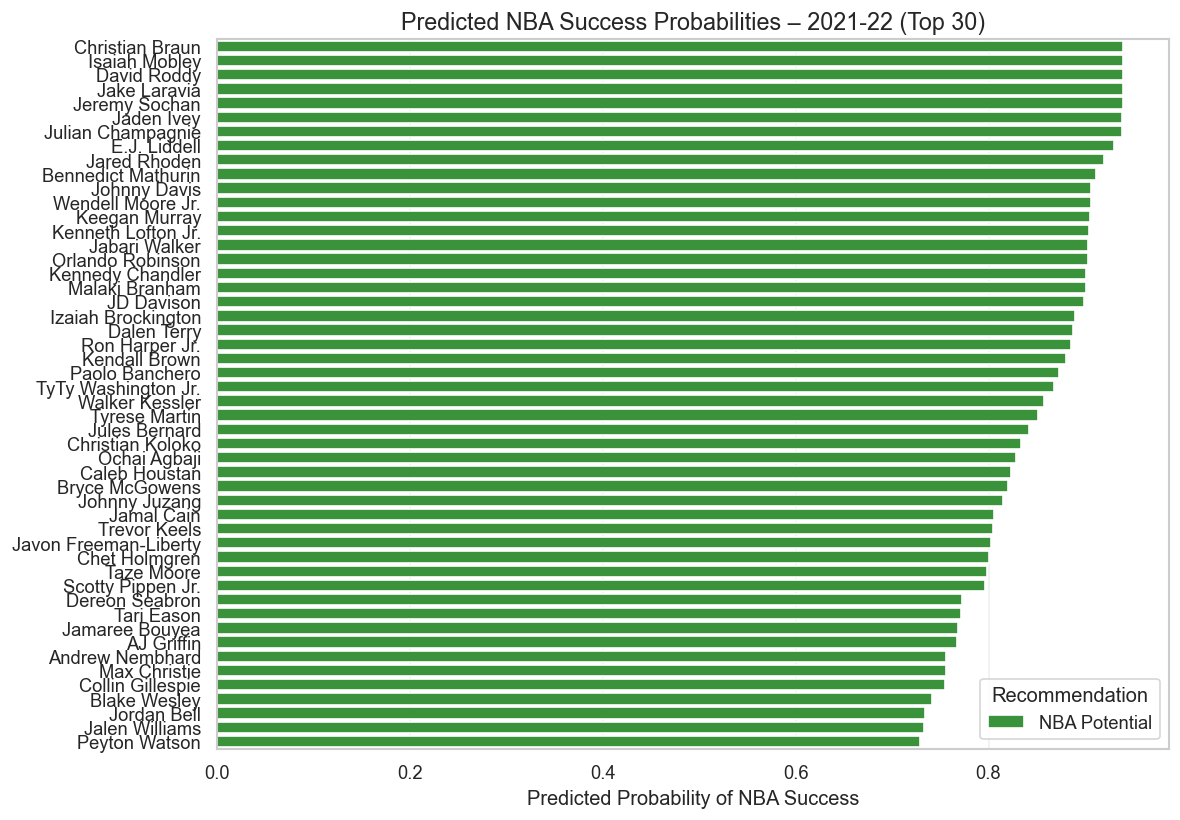

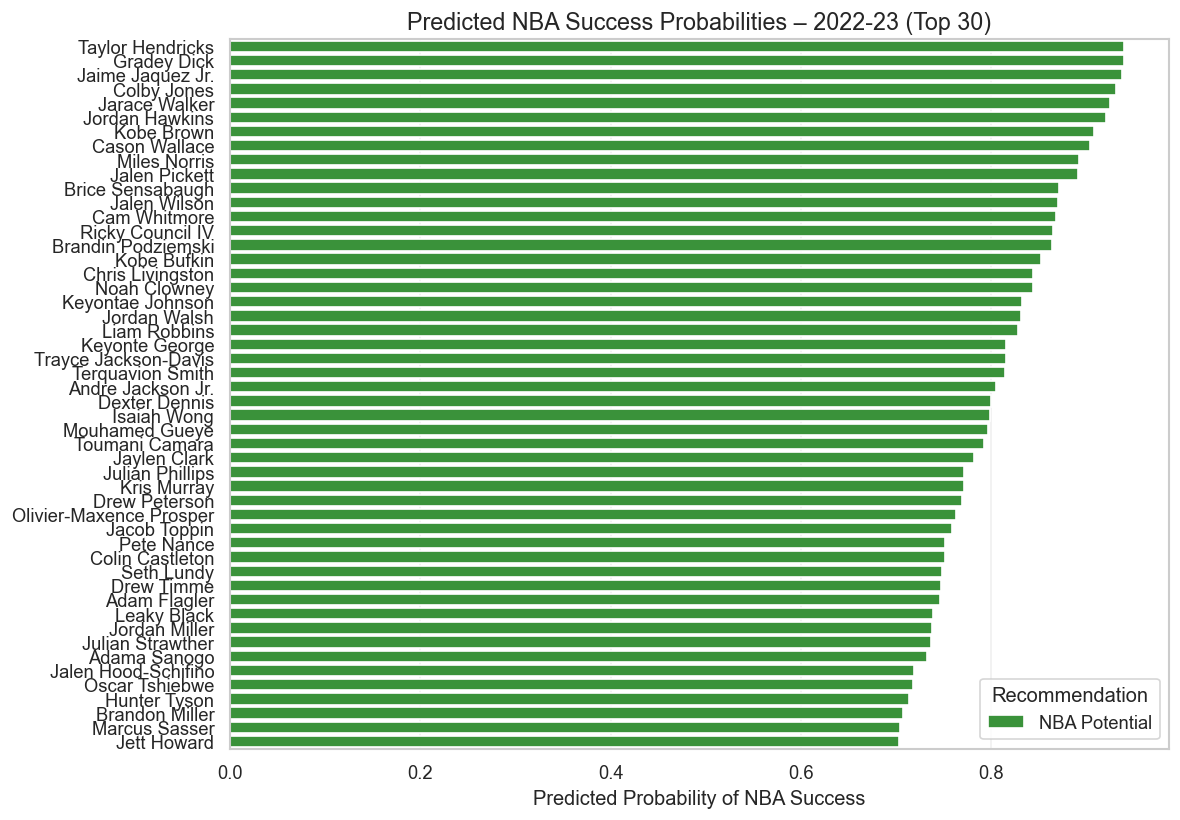

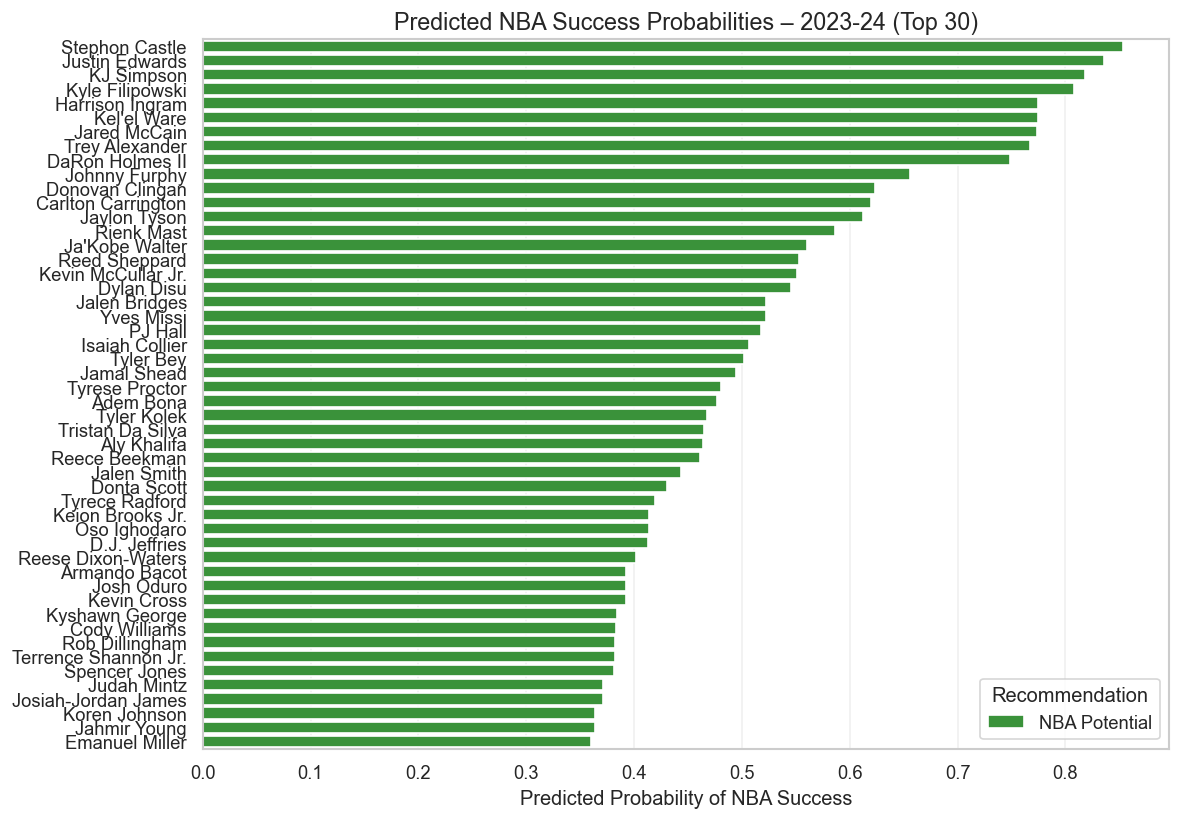

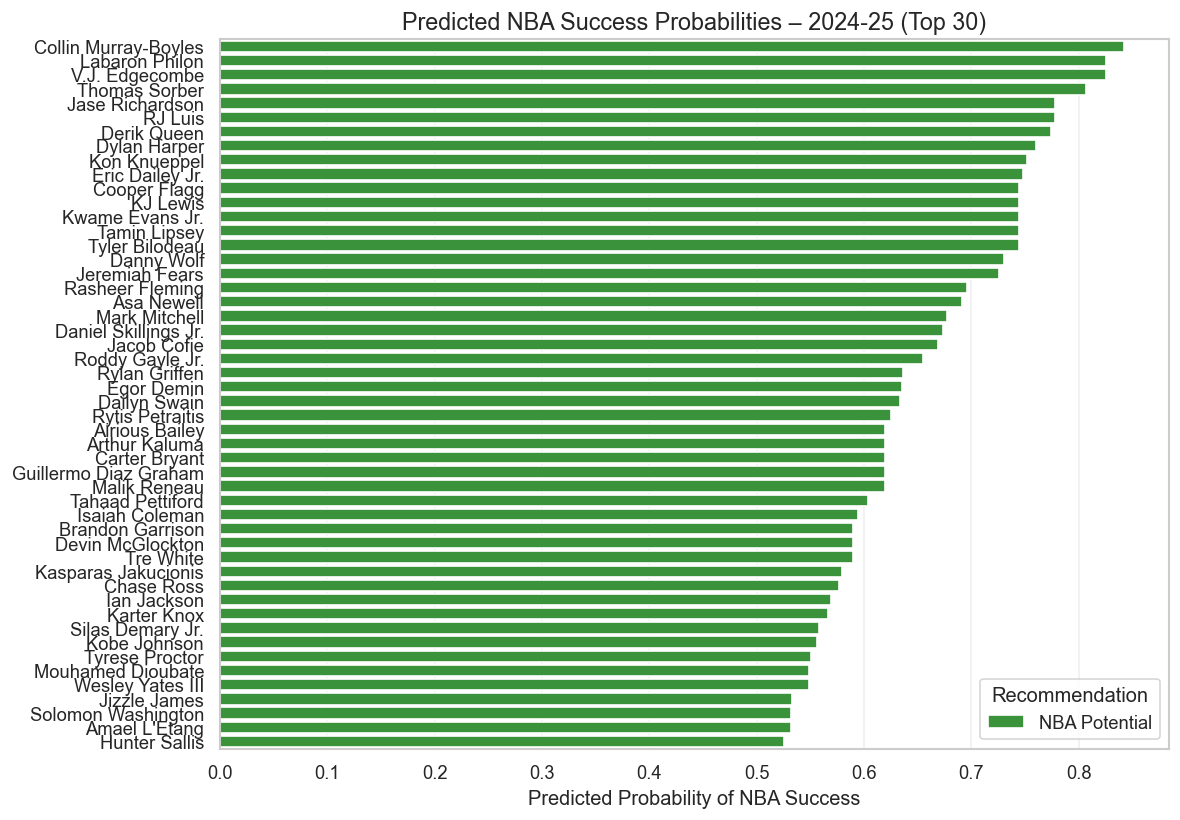

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

for season, data in draft_board.groupby("Season"):
    plt.figure(figsize=(10, 7))
    sns.barplot(
        data=data.sort_values("Rank"),
        y="Player",
        x="pred_proba",
        hue="Recommendation",
        dodge=False,
        palette={"NBA Potential": "#2ca02c", "Pass": "#d62728"}
    )
    plt.title(f"Predicted NBA Success Probabilities – {season} (Top 30)", fontsize=14)
    plt.xlabel("Predicted Probability of NBA Success")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


In [46]:
cols = [
    "Season", "Rank", "Player", "Team", "Pos", "Round", "Pick",
    "pred_proba", "Recommendation", "NBA", "NBA_YOS"
]
draft_board[cols].to_csv("NBA_Potential_top30_by_season.csv", index=False)
